### Imports

In [1]:
!pip install line_profiler
%load_ext line_profiler

!pip install py-heat-magic
%load_ext heat

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
from os import path
import os

import typing as t
import datetime

import copy
import numpy as np
import pandas as pd
import dataframe_image as dfi
import re
from scipy.interpolate import griddata

import matplotlib as mpl
import matplotlib.pyplot as plt

import random
import math
import scipy

In [4]:
from numberWithUncertainty import numberWithUncertainty 

from classificationError import remove_bin_class_bias
from classificationError import remove_bin_class_bias
from utils import bubble_sort_dicts_based_on_property 

from data_analysis_utils import *

import config
from config import debug_imgs_path_used, debug_imgs_prefix

In [5]:
# Context-Driven Abbreviations

# cs        Color Space
# oob       Out Of Bootrap Evaluation | It's Results
# b_method  Best Method
# summ      Summary
# HP(s)     Hyperparameter(s)
# freq      Frequence

# _p_   per

### DataSets

In [6]:
from typeguard import check_type
from analysisTypes import *

In [7]:
import condoAnalysisData

validDataCollection = t.TypeVar("validDataCollection", bound=t.Union[t.Dict[str, technique_oriented_results_t], t.Dict[str, "validDataCollection"]])
    
CM_EVAL_2024 = check_type(condoAnalysisData.CIENCIAS_MOLECULARES_EVAL_2024, validDataCollection)


In [8]:
# FIXME: "pos_correction" because data was wrongly processed At First

# FIXME: Why Renaming To This Format
x = pd.DataFrame(CM_EVAL_2024['Kmeans'])
x = x.rename({
    "KNN_K_0.2n": "knn_clusters_0_2",
    "KNN_K_0.4n": "knn_clusters_0_4",
    "KNN_K_0.6n": "knn_clusters_0_6",
    "KNN_K_0.8n": "knn_clusters_0_8",
    "KNN_K_sqrt_n": "knn_clusters_sqrt",
    "KNN_K_n^2/8": "knn_clusters_exp_2_over_8",
    "KNN_K_n^3/8": "knn_clusters_exp_3_over_8"
}, axis=1)
CM_EVAL_2024['Kmeans'] = x.to_dict()

# CHANGE 'data['Kmeans']["KNN_K_0.2n"]["Kmeans_k_20"]' -> 'data["KNN_K_0.2n_Kmeans_k_20"]'
pos_correction_kmeans_n_init_3 = {}
for KNN_K, subMethodsDict in CM_EVAL_2024['Kmeans'].items():
    for KMEANS_K, method_results in subMethodsDict.items():
        pos_correction_kmeans_n_init_3[f"{KNN_K}_{KMEANS_K}"] = method_results

pos_correction_kmeans_n_init_3 = check_type(pos_correction_kmeans_n_init_3, technique_oriented_results_t)

pos_correction_slic = check_type(CM_EVAL_2024['SLIC_min_max'], technique_oriented_results_t)
pos_correction_mean_sd = check_type(CM_EVAL_2024['mean_sd'], technique_oriented_results_t)

In [9]:
# HP: Hyperparameter
method_key_to_HPs_labels_mapper_per_technique = {
    "K-Means + KNN": {
        "knn_clusters_": "KNN K: ",
         "_Kmeans_k_": " | Kmeans K: ",
        
        "_over_": "/",
        "exp_": "N^",
        "_": "." 
    },
    
    "MinMax-Slic": {
        "SLIC_minmax":"",
        "_spxArea_": "Área Superpixel: ",
        "_m_": "px² | m: ",
        "_": "."
    },
    
    "Mean-SD": {
        "mean_sd_threshold_": "β: ",
        "_":"."
    }
}

def method_key_to_HPs_labels(method_key:str, method_key_to_HPs_labels_mapper:dict[str, str]) -> str:
    """
    Change method_key to Hide the tecnique name and convert HPs from identifier form
    To Display-Label Form
        
    Parameters
    ---------
        method_key (str): 
            A String of format: "technique_name_HPs_description"
        method_key_to_HPs_labels_mapper (dict[str, str]): 
            A Dict Describing how to replace each subString of method_key
            Substring Declared First On The Mapper, Will Be Replaced First

    Returns
    ------
        str: HPs in Display-Label Form
        
    Example
    ------
    >>> method_key = "tecnique_A_alpha_2_3"
    >>> mapper = {
    >>>     "tecnique_A_": "",
            "alpha_": "α: ",
            "_": "."
    >>> }
    >>> method_key_to_HPs_labels(method_key, mapper)
    >>>     returns "α: 2.3"
    """
    
    for HP_separator, HP_Prefix in method_key_to_HPs_labels_mapper.items():
        method_key = method_key.replace(HP_separator, HP_Prefix)
        
    return method_key

In [10]:
methods_options = {
    "K-Means + KNN": {
        "technique_label": "K-Means + KNN Inversa",
        "data": pos_correction_kmeans_n_init_3
    },
    "Mean-SD": {
        "technique_label": "Limiarização Mean-SD",
        "data": pos_correction_mean_sd
    },
    "MinMax-Slic": {
        "technique_label": "SLIC-MinMax",
        "data": pos_correction_slic
    }
}

data: technique_oriented_results_t
technique_label: str
method_key_to_HPs_labels_mapper: t.Dict[str, str]

def set_current_technique_data(technique_name:str):
    global data
    global technique_label
    global method_key_to_HPs_labels_mapper
    
    data = check_type(methods_options[technique_name]["data"], technique_oriented_results_t)
    data = copy.deepcopy(data)

    technique_label = methods_options[technique_name]["technique_label"]

    method_key_to_HPs_labels_mapper = {}
    if technique_name in method_key_to_HPs_labels_mapper_per_technique:
        method_key_to_HPs_labels_mapper = method_key_to_HPs_labels_mapper_per_technique[technique_name]
    


In [11]:
# technique_name = "K-Means + KNN"
# technique_name = "Mean-SD"  
technique_name = "MinMax-Slic"

set_current_technique_data(technique_name)

In [ ]:
# metrics_to_track = ['accuracy', 'balancedAccuracy', 'F1Score', 'time_to_analyze', 'recall', 'specificity', 'precision', 'MCC', 'Ps']
metrics_to_track = ["MCC", "Ps", "time_to_analyze"]

# sort_metric = "MCC"
# sort_metric = "time_to_analyze"
sort_metric = "Ps"

labels_metrics_to_track = {
    'accuracy': 'Acurácia (%)',
    'balancedAccuracy': 'Acurácia Balanceada (%)',
    'F1Score': 'F1-Score (%)',
    "time_to_analyze": "Duração (s)",
    "recall": "Recall (%)",
    "specificity": "Specificity (%)",
    "precision": "Precisão (%)",
    "MCC": "normMCC (%)",
    "Ps": "Ps (%)",
    # 'truePositiveRate': 'Taxa de Verdadeiro Positivo',
}

In [13]:
f_to_get_metric_from_condo_ds = {}
f_to_get_metric_from_condo_ds["time_to_analyze"] = lambda ds, cache=None: pd.DataFrame(ds)["time_to_analyze"]

# Great Parts of Metric Of Interest Are Inside "classification_evaluation_metrics" property
for metric in ['accuracy', 'balancedAccuracy', 'F1Score', "AUC", "recall", "MCC", "Ps", "specificity", "precision"]:
    
    def create_f(metric):
        def getMetric(condo_ds, cache=None):
            
            if cache == None:
                cache = {}
            
            if not "class_eval_metrics_df" in cache:
                cache["class_eval_metrics_df"] = reduce_df_dim(pd.DataFrame(condo_ds), "classification_evaluation_metrics")
            
            class_eval_metrics_df = cache["class_eval_metrics_df"]
            
            return class_eval_metrics_df[metric]
        
        return getMetric
    
    
    f_to_get_metric_from_condo_ds[metric] = create_f(metric)

In [14]:
# Maintain Only Valid Metrics

for metric in [*labels_metrics_to_track.keys()]:
    if (not metric in metrics_to_track):
        del labels_metrics_to_track[metric]

for metric in [*f_to_get_metric_from_condo_ds.keys()]:
    if (not metric in metrics_to_track):
        del f_to_get_metric_from_condo_ds[metric]

In [15]:
quality_prop = sort_metric

### Pre-Process Data

In [16]:
# Converts data: from DataFrame[color_space_oriented_df] -> DataFrame[technique_oriented_df]
color_space_oriented_df = pd.DataFrame(data).T

# Remove Excluded Color Spaces (Just "OKLAB_results")
if ("OKLAB_results" in color_space_oriented_df.keys()):
    color_space_oriented_df.drop("OKLAB_results", axis=1, inplace=True)

In [17]:
# Remove Bias: Ignore Correct Classification of Pixels Masked Out Before Segmentation

def update_condo_ds_class_metrics(condo_ds: condo_ds_t):
    for i, condo_data in enumerate(condo_ds):
        new_metrics = remove_bin_class_bias([i, condo_data["classification_evaluation_metrics"]])
        condo_ds[i]["classification_evaluation_metrics"] = new_metrics
        
    return condo_ds

color_space_oriented_df = color_space_oriented_df.apply(
    lambda method_analysis_data:
        method_analysis_data.apply(
            update_condo_ds_class_metrics
    ),
    axis=0
)

In [18]:
# Normalizing Time: 10 Images [0-9] are (1366x768); 4 Images [10-13] are (1830x1080)
# Scale images [10-13] time of processing, so It fits images [0-9] scale (reference images)

ref_img_size = 1366*768
larger_img_size = 1830*1080
time_normalization_const = ref_img_size/larger_img_size
time_normalizaton_vector = np.array([1]*10 + [time_normalization_const]*4)

def normalize_time(DS_data: condo_ds_t):
    DS_data = pd.DataFrame(DS_data)
    DS_data["time_to_analyze"] = DS_data["time_to_analyze"] * time_normalizaton_vector
    return DS_data.to_dict("records")
    
color_space_oriented_df = color_space_oriented_df.apply(lambda col: col.apply(lambda DS: normalize_time(DS)))

In [19]:
# Injecting Msising Metrics: MCC (Matthews correlation coefficient)
from computeMissingMetrics import * 

def inject_missing_metrics(ds: condo_ds_t) -> condo_ds_t:
    ds_df = pd.DataFrame(ds)
    ds_metrics_df = reduce_df_dim(ds_df, "classification_evaluation_metrics")
    confusion_matrix_series = ds_metrics_df["typesDistribution"]

    ### (norm)MCC
    if "MCC" in metrics_to_track:
        MCC = confusion_matrix_series.apply(lambda confusion_matrix: compute_MCC(confusion_matrix))
        ds_metrics_df["MCC"] = (MCC + 1) / 2 * 100 # Normalizing It
    
    ### Ps
    if "Ps" in metrics_to_track:
        ds_metrics_df["Ps"] = confusion_matrix_series.apply(lambda confusion_matrix: compute_pS(confusion_matrix)) * 100
    
    ### Specificity 
    if "specificity" in metrics_to_track:
        ds_metrics_df["specificity"] = confusion_matrix_series.apply(lambda confusion_matrix: compute_specificity(confusion_matrix)) * 100
    
    ds_df["classification_evaluation_metrics"] = ds_metrics_df.to_dict("records")
    return ds_df.to_dict("records")


In [20]:
color_space_oriented_df = color_space_oriented_df.apply(lambda col: col.apply(lambda ds: inject_missing_metrics(ds)))

### Out Of Bootstrap .362+

In [21]:
"""
This Section Goal Is Not To Implement the OOB.362 Completely
It's Cores Logic Was Implemented, but the training using the Training Set Was Ignored
The purpose of this section is to extract the oob samples just for the testing
This will be done to represent the population, but not all the current dataset to fine-tune the hyperparameters in a no biased way
"""

"\nThis Section Goal Is Not To Implement the OOB.362 Completely\nIt's Cores Logic Was Implemented, but the training using the Training Set Was Ignored\nThe purpose of this section is to extract the oob samples just for the testing\nThis will be done to represent the population, but not all the current dataset to fine-tune the hyperparameters in a no biased way\n"

In [22]:
from bootstrap_sampling import *
from oob_results_sampling import *

In [23]:
valid_oob_results_sets_t = t.NewType("valid_oob_results_sets_t",
                                     t.Literal["test"]|t.Literal["eval"]|t.Literal["train"])


metric_t = t.NewType("metric_t", float|int)
all_samples_mean_metric_t = t.NewType("all_samples_mean_metric_t", metric_t)

oob_samplewise_metric_ds_t = t.NewType("oob_samplewise_metric_ds_t", t.List[metric_t])


method_oob_results_t = (t.NewType(
                        "method_oob_results_t",
                        Dict[valid_oob_results_sets_t, t.Dict[str,
                                oob_samplewise_metric_ds_t | # "metric_ds" (DS Of The Mean Result On Each Sample)
                                all_samples_mean_metric_t] # "metric_mean" (metric_ds mean)
                            ]
                        ))

cs_oriented_oob_results_t = t.NewType("cs_oriented_oob_results_t",
                               t.Dict[valid_color_spaces_t, t.Dict[str, method_oob_results_t]])

In [24]:
# obb_f_name = f"{technique_name}_oob_samples_results_v5_w_ps.data"
obb_f_name = f"{technique_name}_oob_samples_results_v6_05_08_25_w_all_props.data"
oob_results_f_path = path.join("oobCache", obb_f_name)

def _cache_eval_compute_crr_oob_results(cache:str):
    print("Evaluating Cached OOB Data")
    oob_362_plus_results_over_methods_str = re.sub(r"array\((?=\[[^\]\)]*\])", "np.array(", cache)
    return eval(oob_362_plus_results_over_methods_str)

@cache_result(oob_results_f_path, _cache_eval_compute_crr_oob_results)
def _compute_crr_oob_results(color_space_oriented_df, f_to_get_metric_from_condo_ds, sample_amount=300):
    print("Extracting New Cache")
    return compute_oob_362_results_over_methods(color_space_oriented_df, f_to_get_metric_from_condo_ds, sample_amount)

# Previous "oob_362_plus_results_over_methods"
oob_eval_methods_results: cs_oriented_oob_results_t
oob_eval_methods_results = _compute_crr_oob_results(color_space_oriented_df, f_to_get_metric_from_condo_ds, sample_amount=300)

Evaluating Cached OOB Data


In [25]:
# Renaming "train" -> "evaluation"
oob_eval_methods_results = pd.DataFrame(oob_eval_methods_results).apply(lambda col: col.apply(lambda ds: pd.DataFrame(ds).rename(columns={"train": "evaluation"}).to_dict()))

In [26]:
def remove_metric_not_of_interest(oob_results):
    for set_type in ["test", "evaluation"]:
        crr_eval_results = pd.DataFrame([oob_results[set_type]])
        
        metrics_mean_keys = map(lambda metric: f"mean_{metric}", metrics_to_track)
        metrics_ds_keys = map(lambda metric: f"{metric}_ds", metrics_to_track)
        
        results_to_maintain = set([*metrics_mean_keys, *metrics_ds_keys]).intersection(crr_eval_results.columns)
        results_to_maintain_df = crr_eval_results[[*results_to_maintain]]
        
        oob_results[set_type] = results_to_maintain_df.to_dict("records")[0]
    return oob_results

oob_eval_methods_results = oob_eval_methods_results.apply(
    lambda col: 
        col.apply(lambda oob_results:
            remove_metric_not_of_interest(oob_results)
        )
    )

### (Set-Up): OOB Best Methods Results And Sample-Frequency

In [27]:
class best_method_info_t(t.TypedDict):
    name: str
    test_results: Dict[str, float|int] #FIXME create custom type

sample_index = t.NewType("sample_index", int)
method_rank = t.NewType("method_rank", int)
best_methods_p_sample_t = t.NewType("best_methods_p_sample_t",
                                    Dict[sample_index, Dict[method_rank, best_method_info_t]])

In [28]:
# FIXME 
def identify_best_methods_p_sample(methods_results_df:pd.DataFrame, top_n_methods_to_look:int=1) -> best_methods_p_sample_t:
    """
    Selects the top_n_methods_to_look best methods for each sample.
    
    The method performance criterion (perf_crit) depends on the quality property being evaluated.
    
    Parameters
    ----------
    methods_results_df : pd.DataFrame
        A DataFrame containing method results with a hierarchical structure where:
        - Rows represent different methods (method names as index)
        - Columns represent analysis sets ("test", "evaluation")
        - Each cell contains a dictionary with metric results including dataset arrays
    
    top_n_methods_to_look : int, default=1
        Number of top-performing methods to identify per sample. Must be >= 1.
    
    Returns
    -------
    dict
        A nested dictionary with the following structure:
        {
            sample_index: {
                method_rank: {
                    "name": str,           # Method name
                    "test_results": dict   # Mean Test metrics Along All Samples (No datasets)
                }
            }
        }
        
        Where:
        - sample_index: int from 0 to number of samples - 1
        - rank: int from 0 to top_n_methods_to_look - 1 (0 = best performing)
        - test_results: Dictionary of metric values for that sample, with dataset 
          array keys (ending in "_ds") removed
    
    Notes
    -----
    Performance criteria by quality property:
    - normPs, Ps: Minimize absolute distance to 50%
    - time_to_analyze: Minimize execution time
    - All other metrics: Maximize metric value
    
    If The Same Method Presents To Be The Best In Multiple Samples,Their 'test_results'
    Will Be equal in ALl Metrics
    """
    
    # Choosed first Eval Results And a Valid Property to compute sample amount
    sample_amount = len(methods_results_df.iloc[0]["test"][f"{quality_prop}_ds"])
    
    best_method_per_sample = {} # Output Dict
    for sample_i in range(sample_amount):
        best_method_per_sample[sample_i] = {}
        
        # Describing What Means to a Sample Has The Best Quality Metric
        # (For each Possible Quality Metric)
        # What is the perf_crit (excellence criterion)
        # And If It's to Max or Min It
        
        # best_excel_crit_df: 
            # Df {"ANALYSIS_SET": "METHOD_NAME": {"test": perf_crit, "evaluation": "perf_crit"}}
            # Each row: a Best method-Result and it's excellence criterion
        best_perf_crit_df: pd.DataFrame
        
        # (Ps): Performance = Minimize Distance To 50%
        if (quality_prop in ["normPs", "Ps"]):
                
            # performance_criteria
            def get_abs_dist_to_0_5(oob_results: cs_oriented_oob_results_t):
                return abs(oob_results[f"{quality_prop}_ds"][sample_i]-50)
            
            crr_sample_perf_crit_df = methods_results_df.apply(lambda col: col.apply(get_abs_dist_to_0_5))
            best_perf_crit_df = crr_sample_perf_crit_df.nsmallest(top_n_methods_to_look, "evaluation")
            
        # (Other Metrics): Performance = Max or Min Metric Itself
        else:
            
            # excel_crit
            def get_quality_metric_ds(oob_results):
                return oob_results[f"{quality_prop}_ds"][sample_i]
            
            crr_sample_perf_crit_df = methods_results_df.apply(lambda col: col.apply(get_quality_metric_ds), axis=0)
            
            # (time_to_analyze): Min Time
            if (quality_prop == "time_to_analyze"):
                best_perf_crit_df = crr_sample_perf_crit_df.nsmallest(top_n_methods_to_look, "evaluation")
            
            # (Other): Max Metric
            else:
                best_perf_crit_df = crr_sample_perf_crit_df.nlargest(top_n_methods_to_look, "evaluation")
        
        
        # Generate Output Object for Each Top-N Best Methods
        #    {"name": name, "test_results": {mean of each of metrics_to_track}}     
        # Save It on best_method_per_sample[sample_i][nth_best_method]
        for nth_best_method in range(best_perf_crit_df.shape[0]):     
            best_method_per_sample[sample_i][nth_best_method] = {}
            crr_best_method = best_method_per_sample[sample_i][nth_best_method]
            
            crr_best_result_name = best_perf_crit_df.iloc[nth_best_method].name
            crr_best_method["name"] = crr_best_result_name
            
            # Get Test Results & Remove DSs (They Won't Be Used on This Analysis Pipeline)
            best_method_all_oob_res = methods_results_df.loc[crr_best_result_name]
            test_results = best_method_all_oob_res.loc["test"]
            
            DSs_keys = [*map(lambda prop: f"{prop}_ds", metrics_to_track)]
            test_results = pd.DataFrame(test_results).drop(DSs_keys, axis=1).iloc[sample_i].to_dict()
            
            crr_best_method["test_results"] = test_results
            
    return best_method_per_sample

In [29]:
# Along All Eval OOB samples, the same method can be identified as the best one multiple times
# The mean test quality is estimated along these multiple times
# The rate in which each method is said the best (compared to total OOB samples) is computed 

# def compute_test_quality_metrics_and_best_metric_frequency(oob_results):
#TODO: CHANGE NAME
def summary_unique_b_method_from_oob(b_methods_p_sample: best_methods_p_sample_t) -> pd.DataFrame:
    """
    Calculate summary statistics
    for each UNIQUE methods that performed best across on at least 1 OOB sample.
    
    Including (Classification Metrics Mean) and OOB-Samples Frequence In Which the method
    was a best bethod 
    
    Parameters
    ----------
    b_methods_p_sample : best_methods_per_sample_t
        Dict Data-Frame Like containing the best-performing method for each OOB sample.

    Returns
    -------
    pd.DataFrame
        Summary DataFrame with methods as index and the following columns:
        - Mean metric columns: Average performance across all samples where this
          method was best (column names depend on metrics_to_track)
        - 'Was The Best in How Many Samples': Percentage of samples where this
          method performed best (0-100%)
        
        DataFrame is sorted in descending order by the frequency of being best.
    
    Notes
    -----
    - The function assumes that 'test_results' contains identical mean metrics
      across all samples for the same method, using only the first occurrence
    - Percentages are rounded to 2 decimal places
    - The function displays intermediate results for debugging purposes
    
    Examples
    --------
    >>> # Assume best_methods_summary contains bootstrap results
    >>> summary_df = summary_best_methods_mean_metrics_and_freq(bootstrap_results)
    >>> print(summary_df.columns)
    Index(['mean_accuracy', 'mean_f1', 'Was The Best in How Many Samples'])
    >>> print(summary_df.head())
                           mean_accuracy  mean_f1  Was The Best in How Many Samples
    meanSD_HP1              0.92     0.89                              45.50
    SLIC_MINMAX_HP2         0.89     0.85                              32.25
    """
    
    top_methods_names = [*b_methods_p_sample["name"].unique()]

    # best_methods_mean_results: {"Method_Name": DataFrame[Mean_Results]}
    best_methods_mean_results: t.Dict[str, pd.DataFrame] = {}

    for crr_top_method_name in top_methods_names:

        # Returns 1 Row / Samples in which 'crr_top_method_name' had the best results 
        # "test_results" content of all rows are equal, and represents the mean results of all samples
        # So the 0th row, what used as a valid row 
        crr_top_method_entries = b_methods_p_sample.loc[b_methods_p_sample["name"] == crr_top_method_name]
        crr_top_method_mean_results = reduce_df_dim(crr_top_method_entries, "test_results")
        crr_top_method_mean_results = crr_top_method_mean_results.iloc[0]
        
        crr_top_method_mean_results["Was The Best in How Many Samples"] = crr_top_method_entries.shape[0]
        best_methods_mean_results[crr_top_method_name] = crr_top_method_mean_results
    

    best_methods_mean_results = pd.DataFrame(best_methods_mean_results).T

    # Converting Sample Amount to %
    sample_amount_col = best_methods_mean_results["Was The Best in How Many Samples"]
    
    total_of_samples = sample_amount_col.sum()
    sample_amount_col = 100 * sample_amount_col / total_of_samples
    sample_amount_col = sample_amount_col.apply(lambda val: round(float(val), 2))
    
    best_methods_mean_results["Was The Best in How Many Samples"] = sample_amount_col
    
    # Put mean_results_for_best_methods in Descending order
    mean_results_for_best_methods_ordered = best_methods_mean_results.nlargest(best_methods_mean_results.shape[0], "Was The Best in How Many Samples")
    
    return mean_results_for_best_methods_ordered

In [30]:
# Best Results Per Sample (b_method_per_sample)
# Depends On The Evaluation Scope

# Analysis Will Focus on 2 Scopes:
# 1º: Color Space Scope
#   - "What are the best method in each color space?"
cs_b_method_p_sample = None
# 2º: Global Scope
#   - "Among All Tuples Of (Color Space, Techinique, Hyperparameter), which method is the best?"
oob_eval_methods_results_unpacked = None

# unique_b_methods_summ_ranked_by_freq store the
# Summary of Best Methods On Each Scope (Global / Each Color Space)
unique_b_methods_summ_ranked_by_freq = {}

# - Tecnique for (K-Means, ...)
# - Method for (Techinique, Hyperparameter)

In [31]:
# best_method_per_sample is Separated By Color Space
cs_b_method_p_sample = {}

for color_space in [*oob_eval_methods_results.keys()]:
    all_methods_df = reduce_df_dim(oob_eval_methods_results, color_space)
    cs_b_method_p_sample[color_space] = identify_best_methods_p_sample(all_methods_df, top_n_methods_to_look=1)

In [32]:
# Modify oob_eval_methods_results ( DataFrame[{color_space: {method: eval_results}}] )
# Remove Color Spaces Columns
    # And Maintain it as a prefix of method name
    # ('method_name' -> 'color_space method_name')
# Make eval_results keys became the columns of The DataFrame

oob_eval_methods_results_unpacked = pd.DataFrame()
for color_space in oob_eval_methods_results.keys():
    crr_results = oob_eval_methods_results[color_space]
    
    # Remove Columns Name (Get Data and Recreate Series to Remove Metadata)
    crr_results = pd.Series(crr_results.to_dict())
    
    # Prefix Method Name w/ Color Space 
    rm_results_prefix = lambda method_name: f"{color_space.replace("_results", "")} {method_name}"
    formatted_eval_methods_results = crr_results.rename(rm_results_prefix)
    
    # Concat Alredy Indexed Color Spaces, W/ Current One
    oob_eval_methods_results_unpacked = pd.concat([oob_eval_methods_results_unpacked, formatted_eval_methods_results])
    
    # all_color_spaces_best_methods_per_sample = pd.concat([all_color_spaces_best_methods_per_sample, delete_series_name(evaluated_methods_results[color_space].rename(lambda method_name: f"{color_space.replace("_results", "")} {method_name}"))])

# Make eval_results keys became the columns of The DataFrame
oob_eval_methods_results_unpacked = reduce_df_dim(oob_eval_methods_results_unpacked, 0)

# Get Best Methods
b_method_p_sample_global = identify_best_methods_p_sample(oob_eval_methods_results_unpacked, top_n_methods_to_look=1)

In [33]:
def rename_metrics_cols_from_keys_to_labels(df:pd.DataFrame):
    sample_amout_label_map = {"Was The Best in How Many Samples": "Melhor Método em Amostras (%)"}
    df_cols_names_mapper = {**labels_metrics_to_track, **sample_amout_label_map}
    
    return df.rename(lambda col_name: df_cols_names_mapper[col_name.replace("mean_", "")], axis=1)

### Best Methods Global Scope: Summary & Color Space Prevalence

In [34]:
max_methods_to_render_on_saved_df = 5

In [35]:
convert_df_cells_to_str = lambda col: col.apply(lambda cell: str(cell))

In [36]:
# With best Method of each sample (on eval set) on Global Scope - b_method_p_sample_global
# Summarize Unique Best Methods and Sort Them By "Best Method Frequency"
# Export the Top N Best Method to an External File
# Print The Distribution Of Best Methods Along Color Spaces

# For The Best Methods Identified for each eval set
# Quantify the mean quality metrics Estimated for the Test sets
# Quantify the rate in which each methods was said the best for the bootrap sample

global_oob_b_methods_p_sample = (pd.DataFrame(b_method_p_sample_global)
                            .T
                            .pipe(reduce_df_dim, 0))

# summary_unique_b_method_from_oob return is alredy ranked by frequency
unique_b_methods_summ = summary_unique_b_method_from_oob(global_oob_b_methods_p_sample)
unique_b_methods_summ_ranked_by_freq["All Color Spaces"] = unique_b_methods_summ.to_dict("index")

# # If DSs Removal at identify_best_methods_p_sample do not Happens
# # This Line Would Be Necessary to Filter Out the DSs from Renderization
display_columns = ["Was The Best in How Many Samples", *[f"mean_{prop}" for prop in metrics_to_track]]
unique_b_methods_summ = unique_b_methods_summ[display_columns]

# Presentation / Render Pipeline
unique_b_methods_summ = rename_metrics_cols_from_keys_to_labels(unique_b_methods_summ)

# Rename Rows To Hide Techinique (All Tecniques Are The Same = tecnique_name)
# And Put HyperParameters (HPs) On Display (label) form
unique_b_methods_summ = unique_b_methods_summ.rename(
    lambda method_name: 
        method_key_to_HPs_labels(method_name, method_key_to_HPs_labels_mapper)
)

# Save To File, The Top (max_methods_to_render_on_saved_df) 
# Unique Best Methods Summaries
methods_to_render_amount = min(max_methods_to_render_on_saved_df, unique_b_methods_summ.shape[0])

#FIXME Mudar o Título
await dfi.export_async(
    unique_b_methods_summ.apply(convert_df_cells_to_str)
    .iloc[[*range(methods_to_render_amount)]]
    .style
        .set_caption("Melhor Resultado Entre todos HPs e Espaços de Cor")
        .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    ,
    f"./analysisResults/{sort_metric}/{technique_name}/Global Best Method - {technique_name} - {color_space}.png",
)

# Print % Of Best Method For Each Color SPace
#FIXME Melhorar esse TExto e talvez o "Melhor Método em Amostras (%)" tbm ...
print("How Much % of Best Methods Were From Each Color Space?")
print("-------")

# Filter, Best Methods By Color Spaces (CS)
# FIXME: QUal o nome desse índice?
# Changing Indexes "CS METHOD HPs"  -> "CS"
# By Maintaining only 0th substring separated by space (CS)

extract_cs_from_index = lambda name: name.split(" ")[0]
unique_b_methods_summ_reindex_as_cs = unique_b_methods_summ.copy()
unique_b_methods_summ_reindex_as_cs["Color Space"] = [*map(extract_cs_from_index, [*unique_b_methods_summ_reindex_as_cs.index])]

cs_best_methods_distribution = (unique_b_methods_summ_reindex_as_cs
                                .groupby("Color Space")
                                .sum()
                                .nlargest(unique_b_methods_summ_reindex_as_cs.shape[0], "Melhor Método em Amostras (%)")
                                [["Melhor Método em Amostras (%)"]]
                                )   

await dfi.export_async(
    cs_best_methods_distribution.apply(convert_df_cells_to_str)
    .style
        .set_caption("[Global] Distribuíção dos Melhores Métodos entre Os Espaços de Cor")
        .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    ,
    f"./analysisResults/{sort_metric}/{technique_name}/Best Method Distribution Along Color Spaces - {technique_name}.png",
)

print(cs_best_methods_distribution)
print("")
print("ALL")
print("-------")
display(unique_b_methods_summ)
print("")


How Much % of Best Methods Were From Each Color Space?
-------
             Melhor Método em Amostras (%)
Color Space                               
RGB                                  74.01
LAB                                  26.00

ALL
-------


,Melhor Método em Amostras (%),normMCC (%),Ps (%),Duração (s)
RGB Área Superpixel: 400px² | m: 200,46.67,70.962 ± 2.216,56.993 ± 4.585,19.621 ± 2.104
RGB Área Superpixel: 25px² | m: 10,16.00,70.319 ± 2.32,58.563 ± 4.598,324.204 ± 38.547
LAB Área Superpixel: 400px² | m: 50,11.67,71.844 ± 1.881,37.887 ± 5.513,25.764 ± 3.476
RGB Área Superpixel: 400px² | m: 10,10.67,70.107 ± 2.315,58.115 ± 4.481,18.467 ± 1.706
LAB Área Superpixel: 400px² | m: 75,8.33,71.995 ± 1.84,37.968 ± 5.492,33.382 ± 1.903
LAB Área Superpixel: 400px² | m: 200,6.00,71.411 ± 1.721,37.544 ± 5.247,23.107 ± 2.273
RGB Área Superpixel: 225px² | m: 200,0.67,70.909 ± 2.237,58.14 ± 4.596,35.659 ± 3.374


### Results of Methods That Was the Best Most times (Color Spaces Competing with itself)

In [37]:
# For The Best Methods Identified for each eval set
# Quantify the mean quality metrics Estimated for the Test sets
# Quantify the rate in which each methods was said the best for the bootrap sample

for color_space in [*cs_b_method_p_sample.keys()]:
# for color_space in [[*cs_b_method_p_sample.keys()][0]]:
    
    cs_oob_b_methods_p_sample = (pd.DataFrame(cs_b_method_p_sample)
                                .pipe(reduce_df_dim, color_space)
                                .pipe(reduce_df_dim, 0)
                                )
    
    # summary_unique_b_method_from_oob return is alredy ranked by frequency
    unique_b_methods_summ = summary_unique_b_method_from_oob(cs_oob_b_methods_p_sample)
    unique_b_methods_summ_ranked_by_freq[color_space] = unique_b_methods_summ.to_dict("index")
    
    
    # Rounding 2-Decimal-Places
    cols_2_round = ~unique_b_methods_summ.columns.isin(["mean_time_to_analyze"])
    round_cells_vals = lambda col: col.apply(lambda val: round(val, 2))
    
    unique_b_methods_summ.iloc[:, cols_2_round] = unique_b_methods_summ.iloc[:, cols_2_round].apply(round_cells_vals)
    # unique_b_methods_summ["Was The Best in How Many Samples"] = unique_b_methods_summ["Was The Best in How Many Samples"].apply(lambda val: f"{val:.2f}")
    
    # Rename Rows To Hide Techinique (All Tecniques Are The Same = tecnique_name)
    # And Put HyperParameters (HPs) On Display (label) form
    unique_b_methods_summ = rename_metrics_cols_from_keys_to_labels(unique_b_methods_summ)
    mean_results_for_best_methods_to_render = unique_b_methods_summ.rename(lambda method_name: 
        method_key_to_HPs_labels(method_name, method_key_to_HPs_labels_mapper)
    )
    
    # Save To File, The Top (max_methods_to_render_on_saved_df) 
    # Unique Best Methods Summaries
    methods_to_render_amount = min(max_methods_to_render_on_saved_df, unique_b_methods_summ.shape[0])
    await dfi.export_async(
        mean_results_for_best_methods_to_render.apply(convert_df_cells_to_str)
        .iloc[[*range(methods_to_render_amount)]]
        .style
            .set_caption(color_space.replace("_results", ""))
            .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
        ,
        f"./analysisResults/{sort_metric}/{technique_name}/Best Methods At Color Space - {technique_name} - {color_space}.png"
    )
    
    # Logging Results Std Output
    print("")
    print(color_space)
    print("-------")
    display(unique_b_methods_summ)
    print("")


SHLS_results
-------


,Duração (s),Ps (%),normMCC (%),Melhor Método em Amostras (%)
SLIC_minmax_spxArea_400_m_10,11.553 ± 0.943,26.92 ± 5.13,73.92 ± 2.43,80.0
SLIC_minmax_spxArea_400_m_200,25.204 ± 2.926,26.3 ± 5.02,75.06 ± 2.06,20.0




SHSV_results
-------


,Duração (s),Ps (%),normMCC (%),Melhor Método em Amostras (%)
SLIC_minmax_spxArea_400_m_10,11.825 ± 0.926,27.29 ± 5.47,74.28 ± 2.39,64.00
SLIC_minmax_spxArea_400_m_200,26.299 ± 1.88,26.83 ± 5.29,74.79 ± 2.27,35.00
SLIC_minmax_spxArea_400_m_20,18.058 ± 1.133,25.93 ± 4.87,75.08 ± 2.26,0.67
SLIC_minmax_spxArea_400_m_30,14.902 ± 1.225,25.34 ± 4.75,76.18 ± 2.12,0.33




LAB_results
-------


,Duração (s),Ps (%),normMCC (%),Melhor Método em Amostras (%)
SLIC_minmax_spxArea_400_m_75,33.382 ± 1.903,37.97 ± 5.49,72.0 ± 1.84,45.67
SLIC_minmax_spxArea_400_m_50,25.764 ± 3.476,37.89 ± 5.51,71.84 ± 1.88,37.00
SLIC_minmax_spxArea_400_m_200,23.107 ± 2.273,37.54 ± 5.25,71.41 ± 1.72,17.00
SLIC_minmax_spxArea_225_m_200,48.372 ± 5.11,36.66 ± 5.25,71.19 ± 1.74,0.33




LUV_results
-------


,Duração (s),Ps (%),normMCC (%),Melhor Método em Amostras (%)
SLIC_minmax_spxArea_400_m_75,40.862 ± 3.583,29.1 ± 5.01,75.75 ± 2.0,48.67
SLIC_minmax_spxArea_400_m_100,30.851 ± 2.866,29.08 ± 5.02,75.2 ± 2.08,17.33
SLIC_minmax_spxArea_400_m_200,25.32 ± 1.652,28.88 ± 4.93,74.86 ± 2.08,17.33
SLIC_minmax_spxArea_225_m_200,34.624 ± 2.96,28.88 ± 4.9,75.22 ± 2.18,15.33
SLIC_minmax_spxArea_225_m_100,34.701 ± 2.662,28.5 ± 4.96,75.66 ± 2.13,1.33




RGB_results
-------


,Duração (s),Ps (%),normMCC (%),Melhor Método em Amostras (%)
SLIC_minmax_spxArea_400_m_200,19.621 ± 2.104,56.99 ± 4.59,70.96 ± 2.22,69.67
SLIC_minmax_spxArea_25_m_10,324.204 ± 38.547,58.56 ± 4.6,70.32 ± 2.32,18.33
SLIC_minmax_spxArea_400_m_10,18.467 ± 1.706,58.11 ± 4.48,70.11 ± 2.31,11.33
SLIC_minmax_spxArea_225_m_200,35.659 ± 3.374,58.14 ± 4.6,70.91 ± 2.24,0.67


### Correlation of Quality Metrics On Different Color Spaces

In [38]:
# With The Purpose to Compute The Correlation
# For each color space, Lists The Eval Mean Quality Metric for Each Method for Each Sample
# The Lists Must Have their values aligned, 
    # Making SHLS[i] and SHSV[i] refers to 
    # the same method (tecnique, HPs) and same sample idx

# seq_mean_quality_ds_on_each_method_by_cs = (Color_Space:[
#                                             *method_A.samplewise_quality_metric_ds,
#                                             *method_B.samplewise_quality_metric_ds,
#                                             ...])

cs_names = [*oob_eval_methods_results.keys()]

seq_quality_ds_on_each_method_by_cs: t.Dict[valid_color_spaces_t, oob_samplewise_metric_ds_t]
seq_quality_ds_on_each_method_by_cs = {cs: [] for cs in cs_names}

oob_results_method_oriented = oob_eval_methods_results.T

for crr_method in oob_results_method_oriented:
    crr_method_eval_oob_results = (oob_results_method_oriented
                           .pipe(reduce_df_dim, crr_method)
                           .pipe(reduce_df_dim, "evaluation"))
    
    quality_metric_DSs: t.Dict[str, t.List[t.Any]]
    quality_metric_DSs = (crr_method_eval_oob_results[[f"{quality_prop}_ds"]]
                          .to_dict("index"))

    for cs in quality_metric_DSs.keys():
        crr_cs_quality_ds: t.List[float|int] = quality_metric_DSs[cs][f"{quality_prop}_ds"]
        seq_quality_ds_on_each_method_by_cs[cs].extend(crr_cs_quality_ds)

In [39]:
corr_matrix = ( pd.DataFrame(seq_quality_ds_on_each_method_by_cs)
               .corr())

# Render Only Below Main diagonal
lower_diagonal_mask = (np.tril(np.ones(corr_matrix.shape), k=-1)
                    .astype(bool))
corr_matrix = corr_matrix.where(lower_diagonal_mask, "")

# Render & Save Correlation (Latex)
display(corr_matrix)
corr_matrix.to_latex(f"analysisResults/latex/correlation/{technique_label}_correlation_matrix.txt")

,SHLS_results,SHSV_results,LAB_results,LUV_results,RGB_results
SHLS_results,,,,,
SHSV_results,0.985987,,,,
LAB_results,0.40149,0.380011,,,
LUV_results,0.630619,0.602866,0.76065,,
RGB_results,0.440267,0.451742,0.401998,0.556278,


### Heat-Map Classification Metrics - Hyperparameters

In [40]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3_dim_HPs_Quality_metric(result_points, min_quality, max_quality):
    
    for idx in range(len(result_points)-1, -1, -1):
        if (idx <= 0):
            break
        
        prop_a_1, prop_b_1, quality_metric_1 = result_points[idx]
        prop_a_2, prop_b_2, quality_metric_2 = result_points[idx-1]
        
        delta = max_quality - min_quality
        quality_metric_1 = float(quality_metric_1 - min_quality) / delta * 100
        quality_metric_2 = float(quality_metric_2 - min_quality) / delta * 100
        
        mean_quality_metric = (quality_metric_1 + quality_metric_2) / 2
        
        
        x_coord = [prop_a_1, prop_a_2]
        y_coord = [prop_b_1, prop_b_2]
        
        if (technique_name in ["K-Means + KNN", "MinMax-Slic"]):
            d = float(mean_quality_metric)/100
            
        plt.plot(x_coord, y_coord, color=[d, d, d, 1.0])
        plt.scatter(x_coord, y_coord, s=(d*10)**3.2, color=f"{(d**1.2)}")
        # plt.plot(x_coords, y_coords, color=colors, label=color_space)
    
    
   
def plot_3D_surface_HP_quality_metric(x, y, z, interpolation="nearest", view_init=None, figsize=(10, 6)):

    # Grid
    grid_x, grid_y = np.meshgrid(
        np.linspace(min(x), max(x), 50),  
        np.linspace(min(y), max(y), 50)  
    )

    grid_z = griddata((x, y), z, (grid_x, grid_y), method=interpolation)  #'linear', 'cubic', 'nearest'

    # Set-Up Figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, aspect="equal", projection='3d')

    # Plotting
    surf = ax.plot_surface(
        grid_x, grid_y, grid_z,
        cmap=plt.cm.viridis, 
        edgecolor='none',  # Grid Lines,
        vmin=min(z),
        vmax=max(z)
    )
    
    if (not view_init is None):
        ax.view_init(*view_init)
    
    ax.set_box_aspect([1, 1, 0.12]) 
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.6, 1]))

    colorbar = fig.colorbar(surf, ax=ax, shrink=.5, aspect=10, pad=.005)
    cbar_ticks = np.linspace(min(z), max(z), 7).round(2)
    colorbar.set_ticks(cbar_ticks)
    colorbar.set_label(labels_metrics_to_track[quality_prop], loc="center", labelpad=8)
    colorbar.ax.yaxis.set_label_position('left') 

    # Labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Creating Darker C-Map For Scatter Points
    original_cmap = plt.cm.viridis  
    modified_cmap_colors = original_cmap(np.linspace(0, 1, 256*2))
    modified_cmap_colors[:, :3] *= 0.75 

    darker_cmap = mpl.colors.LinearSegmentedColormap.from_list("DarkerViridis", modified_cmap_colors)

    # Scatter for better View
    ax.scatter(x, y, z, c=z, cmap=darker_cmap, norm=mpl.colors.Normalize( vmin=z.min(), vmax=z.max()), linewidth=0.5)

    return fig, ax
    

In [ ]:
heatmap_interpolation = "linear"

def plot_mean_SD_heatmap(methods_results, i):
    B_from_method_label = lambda name: float(name.replace("mean_sd_threshold_", ""))
    methods_results["B"] = methods_results["method_name"].apply(B_from_method_label)
                            
    methods_results[f"mean_{quality_prop}"] = methods_results[f"mean_{quality_prop}"].astype("float")
    
    # Testing for Writing (Not Plotting)
    thresh = 75
    greater_than_thresh = methods_results[methods_results[f"mean_{quality_prop}"] > thresh]
    print(f"{greater_than_thresh["B"].min()} → {greater_than_thresh["B"].max()}")
    
    compute_B_quality_prop_pair_from_row = lambda row: (row["B"], float(row[f"mean_{quality_prop}"]))
    pairs = methods_results.apply(compute_B_quality_prop_pair_from_row, axis=1).to_list()
    pairs = np.array(pairs)
    
    cs_label = color_space.replace("_results", "")
    plt.fill_between(pairs[:, 0], 
                    np.zeros(len(pairs)),
                    pairs[:, 1],
                    label=cs_label,
                    color=plt.cm.viridis( ((4-i)/4)**1.2)
                    )

    plt.legend(loc="lower right")
    plt.ylabel(labels_metrics_to_track[quality_prop])
    plt.xlabel("β")


def plot_kmeans_inverse_knn_heatmap(methods_results, extract_HPs_from_methods_name_df):

    def KNN_K_from_method_label(label, N):
        KNN_K_str:str = re.sub(r"KNN K:\s*([^\|]*)\|.*", r" \1", label).replace("_", ".").replace(" ", "")
        
        if (KNN_K_str.replace(".", "").isdigit()):
            return N * float(KNN_K_str)
        
        elif (KNN_K_str == "sqrt"):
            return N ** 0.5
        
        elif (KNN_K_str.startswith("N^")):
            return N ** eval(KNN_K_str.replace("N^", ""))
        
    # For Rendering Dynamic Values for K (as 0.2N)
    N = 100
    methods_results["method_name"] = (methods_results["method_name"]
                                        .apply(extract_HPs_from_methods_name_df))

    methods_results["KNN_K"] = (methods_results["method_name"]
                                .apply(lambda name: KNN_K_from_method_label(name, N))
                                .astype("float")
                                )
    
    methods_results["Kmeans_K"] = (methods_results["method_name"]
                                    .apply(lambda name: re.sub(r".*Kmeans K: (\d*)", r"\1", name))
                                    .astype("float")
                                    )
    
    # Testing For Values > Than Some Val (Interesting for descriptios, not for graph)
    thresh = 74.5
    greater_than_thresh = methods_results[methods_results[f"mean_{quality_prop}"] > thresh]
    print(f"K-Kmeans: {greater_than_thresh["Kmeans_K"].min()} → {greater_than_thresh["Kmeans_K"].max()} | {greater_than_thresh["Kmeans_K"].unique()}")

    # Plotting
    fig, ax = (plot_3D_surface_HP_quality_metric(methods_results["KNN_K"], 
                                                    methods_results["Kmeans_K"], 
                                                    methods_results[f"mean_{quality_prop}"].astype("float"),
                                                view_init=(90, -90, 0), figsize=(10, 6),
                                                interpolation=heatmap_interpolation)
                )
    
    plt.title(color_space.replace("_results", ""))
    # ax.set_title(technique_label, loc="center", x=0.63)

    # X
    ax.tick_params(axis="x", pad=5)
    ax.set_xlabel("KNN-K", labelpad=10)
    # ax.set_xlim(0, 800)

    # Y
    ax.tick_params(axis="y", pad=10)
    ax.set_ylabel("Kmeans-K", labelpad=18)
    # ax.set_ylim(0, 300)

    # Z
    ax.set_zlabel("")
    ax.set_zticks([])

    return fig, ax


def plot_min_max_slic_heatmap(methods_results, extract_HPs_from_methods_name_df):
    methods_results["method_name"] = (methods_results["method_name"]
                                        .apply(extract_HPs_from_methods_name_df))
    
    # Extract HPs from HPs Label

    # Area
    area_from_HPs_label = lambda name: re.sub(r"Área Superpixel:\s*(\d+)px².*",r"\1", name)
    methods_results["area"] = (methods_results["method_name"]
                                .apply(area_from_HPs_label)
                                .astype("float")
                                )
    # m
    m_from_HPs_label = lambda name: re.sub(r".*m:\s*(\d+).*",r"\1", name)
    methods_results["m"] = (methods_results["method_name"]
                            .apply(m_from_HPs_label)
                            .astype("float"))
    
    # Plotting
    fig, ax = plot_3D_surface_HP_quality_metric(methods_results["area"], 
                                                methods_results["m"], 
                                                methods_results[f"mean_{quality_prop}"].astype("float"),
                                                view_init=(90, -90, 0),
                                                figsize=(10, 6),
                                                interpolation=heatmap_interpolation)
    
    ax.set_title(color_space.replace("_results", ""))
    
    # X Axis
    ax.set_xlabel("Área do Superpixel", labelpad=10)
    ax.tick_params(axis="x", pad=5)
    # ax.set_xlim([25, 400])

    # Y Axis 
    ax.set_ylabel("m", labelpad=18)
    ax.tick_params(axis="y", pad=10)
    # ax.set_ylim([0, 100])

    # Z Axis 
    ax.set_zlabel("")
    ax.set_xticks([25, 100, 160, 225, 310, 400])
    ax.set_zticks([])

    return fig, ax


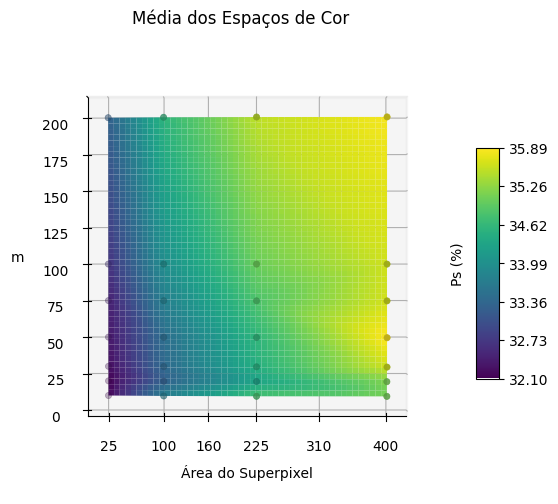

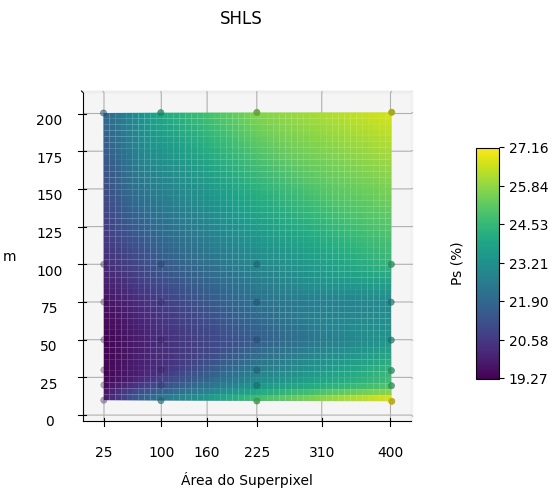

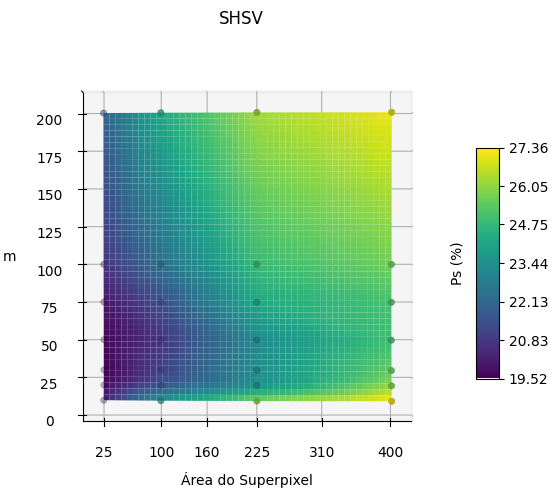

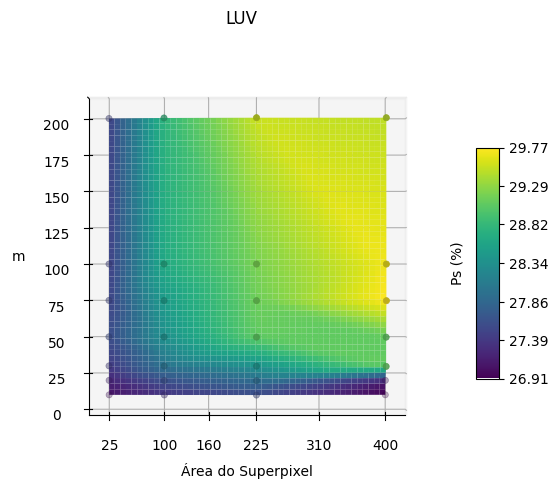

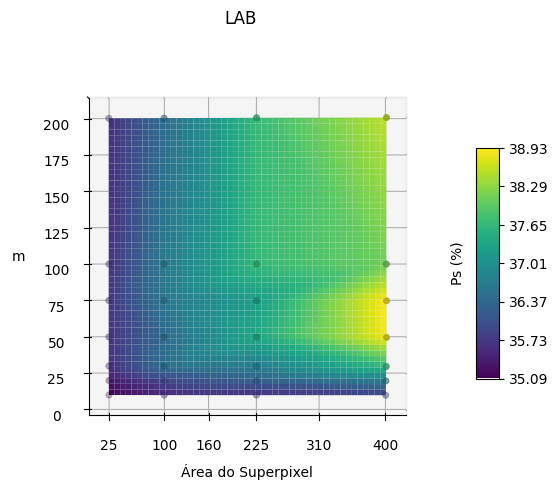

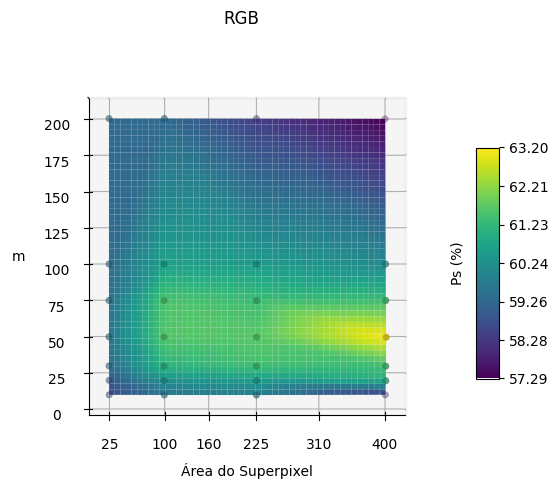

In [42]:
# cs_keys_render_heatmap = [*oob_362_plus_results_over_methods.keys()]
# cs_keys_render_heatmap = [oob_362_plus_results_over_methods.keys()[1]]
# cs_keys_render_heatmap = ["Média dos Espaços de Cor"]
cs_keys_render_heatmap = ["Média dos Espaços de Cor", "SHLS_results", "SHSV_results", "LUV_results", "LAB_results", "RGB_results"]

extract_HPs_from_methods_name_df = lambda name: method_key_to_HPs_labels(name, method_key_to_HPs_labels_mapper)

for i, color_space in enumerate(cs_keys_render_heatmap):
    SORTING_ANALYSIS_SET = "evaluation"
    
    if (color_space == "Média dos Espaços de Cor"):
        methods_results = pd.DataFrame()
        methods_names = oob_eval_methods_results.T.keys()
        
        for method_name in methods_names:
            method_oob_results = reduce_df_dim(oob_eval_methods_results.T, method_name)
            method_oob_eval_results = reduce_df_dim(method_oob_results, SORTING_ANALYSIS_SET)[[f"mean_{prop}" for prop in metrics_to_track]]
            methods_results[method_name] = method_oob_eval_results.copy().astype("float").mean()

        # methods_results = methods_results
        methods_results = methods_results.T.reset_index()
        methods_results = methods_results.rename({"index": "method_name"}, axis=1)
            
    else:
        methods_results = reduce_df_dim(oob_eval_methods_results, color_space)[[SORTING_ANALYSIS_SET]]
        methods_results = reduce_df_dim(methods_results, SORTING_ANALYSIS_SET)
        
        methods_results = methods_results.reset_index()
        methods_results = methods_results.rename({"index": "method_name"}, axis=1)

        # Looking Specific Value
        # if (color_space == "LUV_results"):
        #     display(methods_results[methods_results["method_name"] == "knn_clusters_exp_3_over_8_Kmeans_k_80"])
        # elif (color_space == "SHLS_results"):
        #     display(methods_results[methods_results["method_name"] == "knn_clusters_0_6_Kmeans_k_80"])
        # display("##############")
        
    if (technique_name == "Mean-SD"):       
       plot_mean_SD_heatmap(methods_results, i)
        
    elif (technique_name == "K-Means + KNN"):
        plot_kmeans_inverse_knn_heatmap(methods_results, extract_HPs_from_methods_name_df)    
    
    elif (technique_name == "MinMax-Slic"):
        plot_min_max_slic_heatmap(methods_results, extract_HPs_from_methods_name_df)

    # Saving Image
    heatmap_figs_path = path.join("analysisResults", sort_metric, technique_name, "heatmaps")
    if not path.exists(heatmap_figs_path):
        os.makedirs(heatmap_figs_path)

    heatmap_fname = f"{technique_name} - {color_space} - {quality_prop} HPs Heatmap.png"
    plt.savefig(
        path.join(heatmap_figs_path, heatmap_fname),
        bbox_inches="tight"
    )

    plt.show()

with open(
    path.join(heatmap_figs_path, "lastCreation"), "w" 
    ) as f:
    f.write(datetime.datetime.now(datetime.timezone.utc).isoformat())

### Dispersion Of Metrics along Methods (Eval Samples)

In [43]:
### Dispersion Of Methods (Eval Samples)

print("================================")
print("Mean ± Dispersion Of Metrics along Methods (Eval Samples)")
print("================================")

dispersion_on_color_space = pd.DataFrame()

for color_space in oob_eval_methods_results.keys():
    methods_on_color_space = reduce_df_dim(pd.DataFrame(oob_eval_methods_results), color_space)
    methods_on_color_space_test_results = reduce_df_dim(methods_on_color_space, "evaluation")
    
    # Remove DSs colummns
    methods_on_color_space_test_results.drop(methods_on_color_space_test_results.columns[methods_on_color_space_test_results.columns.isin([*map(lambda metric: f"{metric}_ds", metrics_to_track)])], axis=1, inplace=True)
    
    # Ignoring metric's uncertainty because this would result on mean dispersion having double uncertainty: 
        # because of OOB mean & bevause color space dispersion
        # As OOB dispersion is alredy represented in other graph, 
        # it will be ignored to make easier to understand the uncertainty as color space dispersion
    dispersion_of_cols = methods_on_color_space_test_results.apply(lambda col: mean_w_precision(col.apply(lambda x: float(x))), axis=0)
    dispersion_on_color_space[color_space] = dispersion_of_cols
    
    # With OOB Dispersion
    # dispersion_of_cols = methods_on_color_space_test_results.apply(lambda col: mean_w_precision(col))
    
    print("")
    print(color_space)
    print("-------")
    display(dispersion_of_cols)
    
dispersion_on_color_space = dispersion_on_color_space.T
mean_dispersion_along_color_space = dispersion_on_color_space.apply(lambda col: mean_w_precision(col.apply(lambda x: x.uncertainty)), axis=0)

print()
display(dispersion_on_color_space)
print("Mean Dispersion Along Color Spaces ")
print("-------")
display(mean_dispersion_along_color_space)

Mean ± Dispersion Of Metrics along Methods (Eval Samples)

SHLS_results
-------


mean_time_to_analyze    111.975 ± 118.18
mean_Ps                   22.396 ± 2.251
mean_MCC                  77.173 ± 1.079
dtype: object


SHSV_results
-------


mean_time_to_analyze    105.974 ± 110.726
mean_Ps                    23.186 ± 2.422
mean_MCC                   76.869 ± 1.102
dtype: object


LAB_results
-------


mean_time_to_analyze    112.909 ± 116.644
mean_Ps                    36.636 ± 1.083
mean_MCC                   71.736 ± 0.219
dtype: object


LUV_results
-------


mean_time_to_analyze    117.553 ± 128.536
mean_Ps                    28.245 ± 0.891
mean_MCC                   75.747 ± 0.217
dtype: object


RGB_results
-------


mean_time_to_analyze    157.447 ± 209.187
mean_Ps                    60.171 ± 1.286
mean_MCC                   70.649 ± 0.215
dtype: object

,mean_time_to_analyze,mean_Ps,mean_MCC
SHLS_results,111.975 ± 118.18,22.396 ± 2.251,77.173 ± 1.079
SHSV_results,105.974 ± 110.726,23.186 ± 2.422,76.869 ± 1.102
LAB_results,112.909 ± 116.644,36.636 ± 1.083,71.736 ± 0.219
LUV_results,117.553 ± 128.536,28.245 ± 0.891,75.747 ± 0.217
RGB_results,157.447 ± 209.187,60.171 ± 1.286,70.649 ± 0.215


Mean Dispersion Along Color Spaces 
-------


mean_time_to_analyze    136.655 ± 36.718
mean_Ps                    1.587 ± 0.627
mean_MCC                   0.566 ± 0.428
dtype: object

### Best Methods (Test Samples Only)

In [44]:
# Rendering OB.632+ CV Quality & Variance Estimates for All Test sets from oob samples

print("================================")
print("TOP 15 BEST METHODS FOR TEST SETS")
print("================================")

for color_space in oob_eval_methods_results.keys():
    methods_on_color_space = reduce_df_dim(pd.DataFrame(oob_eval_methods_results), color_space)
    methods_on_color_space_test_results = reduce_df_dim(methods_on_color_space, "test")
    # Remove DSs colummns
    methods_on_color_space_test_results.drop(methods_on_color_space_test_results.columns[methods_on_color_space_test_results.columns.isin([*map(lambda metric: f"{metric}_ds", metrics_to_track)])], axis=1, inplace=True)
    
    ordered_by_largest_quality = methods_on_color_space_test_results.astype("float").nlargest(15, f"mean_{sort_metric}")
    best_method = ordered_by_largest_quality.iloc[0]
    
    print("")
    print(color_space)
    print("-------")
    display(ordered_by_largest_quality)
    print("")
    print(f"{best_method.name}: {round(best_method[f"mean_{sort_metric}"], 2)}%")

TOP 15 BEST METHODS FOR TEST SETS

SHLS_results
-------


,mean_time_to_analyze,mean_Ps,mean_MCC
SLIC_minmax_spxArea_400_m_10,11.552919,26.921800,73.917156
SLIC_minmax_spxArea_400_m_200,25.204242,26.302224,75.056770
SLIC_minmax_spxArea_225_m_200,31.799940,25.327218,76.035684
SLIC_minmax_spxArea_225_m_10,27.999342,24.807269,75.517461
SLIC_minmax_spxArea_400_m_20,18.009650,24.534575,75.788847
SLIC_minmax_spxArea_400_m_30,15.150852,24.302479,76.138178
SLIC_minmax_spxArea_400_m_100,32.914980,24.088746,76.650344
SLIC_minmax_spxArea_100_m_200,80.882336,23.791574,76.533696
SLIC_minmax_spxArea_400_m_50,22.611307,23.083066,76.511989
SLIC_minmax_spxArea_225_m_20,30.287918,23.066559,76.608183



SLIC_minmax_spxArea_400_m_10: 26.92%

SHSV_results
-------


,mean_time_to_analyze,mean_Ps,mean_MCC
SLIC_minmax_spxArea_400_m_10,11.825486,27.293283,74.276855
SLIC_minmax_spxArea_400_m_200,26.299331,26.832705,74.786568
SLIC_minmax_spxArea_225_m_200,41.610682,25.986462,76.146793
SLIC_minmax_spxArea_400_m_20,18.058129,25.931660,75.080147
SLIC_minmax_spxArea_225_m_10,21.864188,25.777606,75.614681
SLIC_minmax_spxArea_400_m_100,26.005587,25.344289,76.037071
SLIC_minmax_spxArea_400_m_30,14.902177,25.339756,76.178193
SLIC_minmax_spxArea_400_m_75,31.760811,24.825414,75.458695
SLIC_minmax_spxArea_400_m_50,19.453502,24.748793,75.641209
SLIC_minmax_spxArea_225_m_100,34.192127,24.627819,76.435326



SLIC_minmax_spxArea_400_m_10: 27.29%

LAB_results
-------


,mean_time_to_analyze,mean_Ps,mean_MCC
SLIC_minmax_spxArea_400_m_75,33.382060,37.967877,71.995000
SLIC_minmax_spxArea_400_m_50,25.763843,37.886711,71.843770
SLIC_minmax_spxArea_400_m_200,23.106572,37.544078,71.410566
SLIC_minmax_spxArea_400_m_100,25.554057,37.114173,71.668247
SLIC_minmax_spxArea_225_m_200,48.372418,36.663393,71.193666
SLIC_minmax_spxArea_400_m_30,19.499594,36.632831,71.482412
SLIC_minmax_spxArea_225_m_100,33.898278,36.608399,71.434844
SLIC_minmax_spxArea_225_m_50,35.524683,36.350838,71.627699
SLIC_minmax_spxArea_225_m_75,33.646332,36.177752,71.570621
SLIC_minmax_spxArea_225_m_30,35.365838,35.677293,71.666743



SLIC_minmax_spxArea_400_m_75: 37.97%

LUV_results
-------


,mean_time_to_analyze,mean_Ps,mean_MCC
SLIC_minmax_spxArea_400_m_75,40.862321,29.096590,75.751871
SLIC_minmax_spxArea_400_m_100,30.851416,29.075478,75.204029
SLIC_minmax_spxArea_225_m_200,34.624029,28.883909,75.219529
SLIC_minmax_spxArea_400_m_200,25.320495,28.876845,74.860152
SLIC_minmax_spxArea_225_m_100,34.701458,28.502270,75.656010
SLIC_minmax_spxArea_400_m_50,24.397189,28.383999,75.608995
SLIC_minmax_spxArea_225_m_75,33.830732,28.382685,75.522501
SLIC_minmax_spxArea_400_m_30,21.251713,28.360015,75.214043
SLIC_minmax_spxArea_225_m_50,34.955350,28.320413,75.574958
SLIC_minmax_spxArea_100_m_200,71.273144,28.056852,75.274861



SLIC_minmax_spxArea_400_m_75: 29.1%

RGB_results
-------


,mean_time_to_analyze,mean_Ps,mean_MCC
SLIC_minmax_spxArea_400_m_50,20.915982,62.972390,70.940677
SLIC_minmax_spxArea_100_m_50,75.249325,61.537955,70.443763
SLIC_minmax_spxArea_225_m_50,876.435861,61.515125,70.279777
SLIC_minmax_spxArea_100_m_75,78.024293,61.459545,70.545929
SLIC_minmax_spxArea_225_m_30,35.254058,61.261948,70.369730
SLIC_minmax_spxArea_400_m_30,18.987743,61.206963,70.584789
SLIC_minmax_spxArea_225_m_75,33.625322,61.181477,70.457335
SLIC_minmax_spxArea_400_m_75,35.212159,61.131742,70.548971
SLIC_minmax_spxArea_100_m_30,162.278374,61.058728,70.326256
SLIC_minmax_spxArea_400_m_20,15.979035,60.916081,70.233503



SLIC_minmax_spxArea_400_m_50: 62.97%


### Are The Results Of The Multiple Methods pretty Distinct For The Same Imgs? *(SD for Same Idx Condo Img Results)*

In [45]:
def analysis_data_series_to_quality_metrics_df(analysis_data_series):
    return pd.DataFrame(
        analysis_data_series.apply(lambda data: data["classification_evaluation_metrics"])     
        .to_list()
    )

In [46]:
def compute_quality_measurements_from_analysis_data_series(data_all_methods_about_specific_condo_index):
    
    # quality_metrics_separated_by_condo_idx_df = analysis_data_series_to_quality_metrics_df(data_all_methods_about_specific_condo_index)[metrics_to_track]
    data_all_methods_about_specific_condo_index = pd.DataFrame(data_all_methods_about_specific_condo_index.to_dict()).transpose()
    quality_metrics_separated_by_condo_idx_df = pd.DataFrame()
    for metric, method_to_extract in f_to_get_metric_from_condo_ds.items():
        quality_metrics_separated_by_condo_idx_df[metric] = method_to_extract(data_all_methods_about_specific_condo_index)

    mean_quality_metrics_separated_by_condo_idx_df = quality_metrics_separated_by_condo_idx_df.apply(mean_w_precision, axis=0)
    
    return mean_quality_metrics_separated_by_condo_idx_df


def calculate_quality_measurements_from_each_condo_idx_separetely(condo_analysis_series):
    return condo_analysis_series.apply(lambda data_all_methods_about_specific_condo_index: 
        compute_quality_measurements_from_analysis_data_series(data_all_methods_about_specific_condo_index)
    ).transpose()


def print_uncertainty_mean_of_Series(series, text="Uncertainty Mean:"):
    print("")
    print(text)
    print("---")
    print(series.apply(lambda x: np.array([*map(lambda val: val.uncertainty, x.to_list())]).mean()))
    print("")

In [47]:
# Quantify Mean Acc + Uncertainty Presented By Each Condo Idx ---

flattened_color_space_oriented_data = color_space_oriented_df.stack().reset_index()[0].to_list() # To Flatten Multi-Column Table

#To Quantify The Uncertainty Of All COndos, Independetly of Condo Idx
# Why Does This result So Different Of The Mean of Each Condo iDx uncertainty mean
# flattened_color_space_oriented_data = pd.DataFrame(m).stack().reset_index()[0]

# ---
condo_indexed_data_df = pd.DataFrame(flattened_color_space_oriented_data)

all_db_mean_quality_of_each_condo_separetely = calculate_quality_measurements_from_each_condo_idx_separetely(condo_indexed_data_df)
print(all_db_mean_quality_of_each_condo_separetely)
print_uncertainty_mean_of_Series(all_db_mean_quality_of_each_condo_separetely)

      time_to_analyze             MCC               Ps
0     91.303 ± 98.966  65.498 ± 2.963   31.565 ± 6.413
1     91.838 ± 97.188  59.352 ± 4.056   15.32 ± 15.704
2     90.386 ± 95.025  64.927 ± 4.579    22.33 ± 9.899
3     93.182 ± 98.291  73.372 ± 1.927  58.686 ± 15.511
4     89.183 ± 94.143  77.649 ± 6.883  26.766 ± 20.868
5      88.461 ± 97.23  74.899 ± 4.811   23.607 ± 18.28
6     90.248 ± 95.397   87.32 ± 0.975  61.171 ± 14.905
7      91.15 ± 96.626   77.302 ± 5.49  17.041 ± 18.193
8    94.014 ± 101.396    75.13 ± 6.19  33.491 ± 20.105
9   137.466 ± 564.928   66.81 ± 4.814  30.559 ± 21.997
10   180.285 ± 206.93  83.142 ± 3.078  20.531 ± 26.475
11  235.519 ± 723.588  77.995 ± 5.018   54.804 ± 18.24
12  172.547 ± 183.127  74.857 ± 3.288  52.677 ± 16.381
13  175.009 ± 190.848  83.664 ± 1.237    32.2 ± 18.414

Uncertainty Mean:
---
time_to_analyze    195.977491
MCC                  3.950640
Ps                  17.241618
dtype: float64



In [48]:
# Quantify Mean Acc + Uncertainty Presented By Each Condo Idx Divided by Color Space ---

flattened_analysis_data_from_each_color_space = {}
for color_space in color_space_oriented_df.keys():
    flattened_analysis_data_from_each_color_space[color_space] = pd.DataFrame(color_space_oriented_df[color_space].to_list())
    each_condo_idx_mean_acc_df = calculate_quality_measurements_from_each_condo_idx_separetely(flattened_analysis_data_from_each_color_space[color_space])
    
    print(f"--- {color_space} ---")
    print(each_condo_idx_mean_acc_df)
    print_uncertainty_mean_of_Series(each_condo_idx_mean_acc_df)

--- SHLS_results ---
      time_to_analyze             MCC              Ps
0     86.938 ± 91.969  64.603 ± 1.653  24.776 ± 2.312
1      94.077 ± 99.89  61.502 ± 2.247    2.434 ± 0.98
2    96.819 ± 103.436   64.827 ± 1.78  14.834 ± 1.489
3   100.056 ± 108.694  73.758 ± 0.364  42.025 ± 0.857
4     89.819 ± 94.068    84.11 ± 2.77   7.899 ± 3.869
5     88.736 ± 92.379  78.284 ± 3.068   9.055 ± 4.852
6     90.062 ± 96.182  86.647 ± 0.625   45.57 ± 3.724
7    93.468 ± 100.376  80.997 ± 1.234    3.16 ± 2.652
8    97.478 ± 111.004  82.082 ± 1.615   9.724 ± 2.233
9      89.35 ± 94.325  70.934 ± 2.522   9.464 ± 1.866
10  162.343 ± 172.263  86.019 ± 0.441   8.817 ± 0.607
11  159.813 ± 169.368  83.863 ± 1.987  51.982 ± 6.925
12  167.872 ± 176.351   78.701 ± 0.72  48.674 ± 2.378
13  161.992 ± 170.267   84.242 ± 1.05  40.698 ± 4.715

Uncertainty Mean:
---
time_to_analyze    120.040926
MCC                  1.576923
Ps                   2.818469
dtype: float64

--- SHSV_results ---
      time_to_analy

### Which Condo Has Biggest Deviation In Same Method Accuracy

In [49]:

def quantify_mean_abs_deviation_of_each_condo_idx(all_condos_analysis_separated_df):

    def quantify_quality_deviation(all_condo_analysis):
        # all_condo_analysis = analysis_data_series_to_quality_metrics_df(all_condo_analysis)[metrics_to_track]
        condo_analysis_metrics_df = data_all_methods_about_specific_condo_index = pd.DataFrame(all_condo_analysis.to_dict()).transpose()
        all_condo_analysis = pd.DataFrame()
        for metric, method_to_extract in f_to_get_metric_from_condo_ds.items():
            all_condo_analysis[metric] = method_to_extract(condo_analysis_metrics_df)
        
        mean = all_condo_analysis[sort_metric].mean()
        all_condo_analysis = all_condo_analysis.apply(lambda x: mean - x, axis=0)
        
        return all_condo_analysis.to_dict("records")

    deviation_each_condo_analysis_df = all_condos_analysis_separated_df.apply(quantify_quality_deviation, axis=0)
    mean_deviation_each_condo_analysis_df = deviation_each_condo_analysis_df.apply(
        lambda specific_metric_deviation_series: 
            pd.DataFrame(specific_metric_deviation_series.to_list()).apply(lambda metric_column: metric_column.abs().mean())
            
        , axis=0).transpose()
    mean_deviation_each_condo_analysis_df = mean_deviation_each_condo_analysis_df.rename({col_name:f"{col_name}_deviation" for col_name in mean_deviation_each_condo_analysis_df.keys()}, axis=1)

    return mean_deviation_each_condo_analysis_df

In [50]:
# Quantify Metric Deviation Of Each Condo Idx from all DB --- 

# Analyze How [[{RecordA}, {RecordA1}], [{RecordB}, {RecordB1}]] --> [{0:{RecordA}, 1:{RecordA1}}, {0:{RecordB}, 1:{RecordB1}}]
all_condos_analysis_separated_by_method_color_space = color_space_oriented_df.stack().reset_index()[0].to_list()
all_condos_analysis_separated_by_method_color_space_df = pd.DataFrame(all_condos_analysis_separated_by_method_color_space)

quantify_mean_abs_deviation_of_each_condo_idx(all_condos_analysis_separated_by_method_color_space_df)

,time_to_analyze_deviation,MCC_deviation,Ps_deviation
0,69.665910,33.933363,5.332392
1,76.982495,44.031297,13.489541
2,70.904710,42.597027,8.776247
3,70.352669,14.685956,13.579122
4,67.941702,50.882516,19.092628
5,68.693684,51.291462,17.506682
6,68.953942,26.148923,13.270141
7,75.018974,60.260685,15.182198
8,70.833324,41.638704,18.944808
9,115.598408,36.251256,20.288137


In [51]:
# Quantify Metric Deviation Of Each Condo Idx Separeted by Color Space --- 

flattened_analysis_data_from_each_color_space = {}
for color_space in color_space_oriented_df.keys():
    flattened_analysis_data_from_each_color_space[color_space] = pd.DataFrame(color_space_oriented_df[color_space].to_list())
    each_condo_idx_mean_abs_deviation_df = quantify_mean_abs_deviation_of_each_condo_idx(flattened_analysis_data_from_each_color_space[color_space])
    
    print(f"--- {color_space} ---")
    print(each_condo_idx_mean_abs_deviation_df)
    print("")
    

--- SHLS_results ---
    time_to_analyze_deviation  MCC_deviation  Ps_deviation
0                   67.492832      39.827284      1.965741
1                   91.643572      59.068376      0.749752
2                   82.689452      49.992550      1.267276
3                   78.048774      31.732633      0.606526
4                   81.919690      76.211040      3.076600
5                   79.691393      69.228729      4.471958
6                   69.311518      41.076811      3.084116
7                   90.308304      77.837326      1.920991
8                   87.754771      72.357866      1.672336
9                   79.970061      61.469889      1.522018
10                 153.525705      77.201870      0.430437
11                 120.854688      31.881680      5.617956
12                 126.654873      30.026181      1.989896
13                 126.782263      43.543811      3.804363

--- SHSV_results ---
    time_to_analyze_deviation  MCC_deviation  Ps_deviation
0            

### Quality Of Methods (Resubsitution)

In [52]:
# QUALITY OF METHODS WITH ALL DB FOR EVAL (NO CROSS-VALIDATION, NO FINE-TUNING, JUST COMPARING) (Resubstitution)

print("--------------------")
print("QUALITY OF METHODS WITH ALL DB FOR EVAL (NO CROSS-VALIDATION, NO FINE-TUNING, JUST COMPARING) (Resubstitution)")
print("--------------------")
print()

methods_quality = {}
for color_space in color_space_oriented_df:
    # Init ---
    methods_quality[color_space] = {}
    methods_condos_ds_df = pd.DataFrame(color_space_oriented_df[color_space].to_dict())
    
    for method_name in methods_condos_ds_df.keys():
        # Getting Metrics Df ---
        crr_method_props = reduce_df_dim(methods_condos_ds_df, method_name)
        
        # Save Tracked Metrics ---
        methods_quality[color_space][method_name] = {}
        for metric, method_to_extract in f_to_get_metric_from_condo_ds.items():
            methods_quality[color_space][method_name][f"mean_{metric}"] = mean_w_precision(method_to_extract(crr_method_props))
        
    # Computing Best Method Of Color Space --
    best_methods_df = pd.DataFrame(methods_quality[color_space]).transpose()
    best_methods_df_w_no_uncertainty = pd.DataFrame(methods_quality[color_space]).transpose()
    
    # Ordering By Quality --
    best_methods_df_w_no_uncertainty[f"mean_{sort_metric}"] = best_methods_df_w_no_uncertainty[f"mean_{sort_metric}"].astype("float")
    # Ordering By Less Uncertainty --
    # best_methods_df_w_no_uncertainty[f"mean_{sort_metric}"] = best_methods_df_w_no_uncertainty[f"mean_{sort_metric}"].apply(lambda x: 100 - x.uncertainty)
    
    top_methods_names = [*best_methods_df_w_no_uncertainty.nlargest(15, f"mean_{sort_metric}").index]
    
    best_methods_df = best_methods_df.loc[top_methods_names]#[[f"mean_{sort_metric}"]]
    
    best_method = best_methods_df.iloc[0]
    methods_quality[color_space]["best"] = {"name": best_method.name, "quality": best_method[f"mean_{sort_metric}"]}
    
    
    # Formatting ---
    def format_best_methods_for_render(row):
        new_row = {}
        new_row[labels_metrics_to_track[sort_metric]] = f"{round(row[f"mean_{sort_metric}"], 2).format_in_str("%")}"
        new_row["Duração"] = f"{round(row["mean_time_to_analyze"], 2)}s"
        
        return pd.Series(new_row)
    
    
    best_methods_df_formatted = best_methods_df.apply(format_best_methods_for_render, axis=1)
    # best_methods_df_formatted = best_methods_df.apply(format_best_methods_for_render, axis=1).rename(lambda name: f"K = {name.replace("Kmeans_k_", "")}")
    # best_methods_df_formatted = best_methods_df.apply(format_best_methods_for_render, axis=1).rename(lambda name: f"Coeff = {name.replace("mean_sd_threshold_", "")}")
    
    
    # Rendering ---    
    print("")
    print(color_space)
    print("-------")
    print(best_methods_df_formatted)
    print("")
    print(f"{best_method.name}: {round(best_method[f"mean_{sort_metric}"], 2)}%")
    
    # dfi.export(best_methods_df_formatted.style
    #            .set_caption(color_space.replace("_results", "")),
    #             f"{technique_name}_best_methods_{color_space}.png")
    

--------------------
QUALITY OF METHODS WITH ALL DB FOR EVAL (NO CROSS-VALIDATION, NO FINE-TUNING, JUST COMPARING) (Resubstitution)
--------------------


SHLS_results
-------
                                        Ps (%)         Duração
SLIC_minmax_spxArea_400_m_10   27.57% ± 19.87%    11.5 ± 3.61s
SLIC_minmax_spxArea_400_m_200  27.04% ± 19.38%  24.95 ± 11.48s
SLIC_minmax_spxArea_225_m_200  26.06% ± 19.48%   31.63 ± 9.63s
SLIC_minmax_spxArea_225_m_10   25.45% ± 18.55%   27.85 ± 9.16s
SLIC_minmax_spxArea_400_m_20   25.15% ± 18.56%   17.89 ± 6.41s
SLIC_minmax_spxArea_400_m_30   24.88% ± 17.71%    15.09 ± 4.6s
SLIC_minmax_spxArea_400_m_100  24.86% ± 19.13%   32.65 ± 8.45s
SLIC_minmax_spxArea_100_m_200  24.43% ± 18.74%  80.45 ± 25.99s
SLIC_minmax_spxArea_400_m_50   23.76% ± 18.28%   22.55 ± 8.32s
SLIC_minmax_spxArea_225_m_20   23.64% ± 18.23%   30.09 ± 9.79s
SLIC_minmax_spxArea_400_m_75   23.42% ± 18.83%  34.27 ± 12.01s
SLIC_minmax_spxArea_225_m_100  23.36% ± 18.77%  33.89 ± 10.24s
SLIC_

---

### Processing Data To Render

In [53]:
""" Data Strucuture to Render: {Color_Space: {mean_{tracked_metric[i]}}} """

' Data Strucuture to Render: {Color_Space: {mean_{tracked_metric[i]}}} '

In [54]:
# sorted_kfolds_eval_method_quality = bubble_sort_dicts_based_on_property(kfolds_eval_method_quality, f"['mean_{sort_metric}']")

In [55]:
# specific_method_data = pd.DataFrame(pd.DataFrame(methods_quality).transpose()["Kmeans_k_200"]).transpose().to_dict("records")[0]
# sorted_specifc_method_quality = bubble_sort_dicts_based_on_property(specific_method_data, f"['mean_{sort_metric}']")

In [56]:
# OOB Data {color_space: {method:resultsDict, ...}} → {color_space: (best_method_name, best_method_result)}
oob_best_method_per_color_space = {color_space: [*best_methods.items()][0] for color_space, best_methods in unique_b_methods_summ_ranked_by_freq.items()}
del oob_best_method_per_color_space["All Color Spaces"]

# {color_space: best_method_results}
oob_best_method_results_per_color_space = {color_space: method_results for color_space, (_, method_results) in oob_best_method_per_color_space.items()}
# {color_space: best_method_name}
oob_best_method_name_per_color_space = {color_space: method_name for color_space, (method_name, _) in oob_best_method_per_color_space.items()}

In [57]:
# method_quality_to_render = specific_method_data
# method_quality_to_render = kfolds_eval_method_quality
method_quality_to_render = oob_best_method_results_per_color_space.copy()
labels_metrics_to_tracks_in_render = {**labels_metrics_to_track, "Was The Best in How Many Samples":"Melhor Métodos em Amostras (%)"}


# Adding "Was The Best in How Many Samples" to df ---
method_quality_to_render = pd.DataFrame(method_quality_to_render)
method_quality_to_render.loc["Was The Best in How Many Samples"] = method_quality_to_render.loc["Was The Best in How Many Samples"].apply(lambda val: numberWithUncertainty(val, 0))

# Changing Time Scale ---
if (technique_name in ["K-Means + KNN", "MinMax-Slic"]):
    method_quality_to_render.loc["mean_time_to_analyze"] = method_quality_to_render.loc["mean_time_to_analyze"].apply(lambda val: val/5)
    labels_metrics_to_tracks_in_render["time_to_analyze"] = "Duração (s/5)"
    

# Saving Changes
method_quality_to_render = method_quality_to_render.to_dict()
# ----

sorted_method_quality_to_render = bubble_sort_dicts_based_on_property(method_quality_to_render, f"['mean_{sort_metric}']") 

metrics_to_plot = copy.deepcopy(metrics_to_track)
# metrics_to_plot = ["Was The Best in How Many Samples", "MCC", "normPs", "time_to_analyze"]
# metrics_to_plot = [ "Ps", "time_to_analyze", quality_prop]
# metrics_to_plot = [*metrics_to_plot, "Was The Best in How Many Samples"]

In [58]:
to_render = {
    "labels": [],
    "features_labels": []
}

for color_space, data in sorted_method_quality_to_render:
    to_render["labels"].append(color_space)

    for metric in metrics_to_plot:
        metric_label = labels_metrics_to_tracks_in_render[metric]
        
        if not metric_label in to_render:
            to_render[metric_label] = []
            to_render["features_labels"].append(metric_label)

        match (metric):
            case "Was The Best in How Many Samples":
                to_render[metric_label].append(round(data[metric], 2))       
            case _:
                to_render[metric_label].append(round(data[f"mean_{metric}"], 2))       
                # if metric == "Ps":
                    # print(round(data[f"mean_{metric}"], 2))
                # else:
                # print(metric)
                    
                 
    
to_render["labels"] = [*map(lambda label: label.replace("_results", ""), to_render["labels"])]

# Render HPs Configurations At Xticks ----

# to_render["labels"] = [*map(lambda label_data: f"{label_data[1]}\n{transform_method_key_into_HPs_labels([*oob_best_method_name_per_color_space.values()][label_data[0]], method_key_to_HPs_labels_mapper)}".replace("|", "\n"), enumerate(to_render["labels"]))]

to_render["labels"] = [*map(lambda color_space_label: f"{color_space_label}\n{method_key_to_HPs_labels(oob_best_method_name_per_color_space[color_space_label+"_results"], method_key_to_HPs_labels_mapper)}".replace("|", "\n"), to_render["labels"])]

### Render Graphs

In [59]:
#TODO: Maybe is better to use pd.DataFrame instead of heightsCollectio & labels
# It will allow different object structures to represent the data - as there are many structures to create dfs
# It will use an alredy know structure so less atrict to use the method

def plt_bars_with_spacing(heightsCollection, labels, overBarLabels=None, width=.25, spacing_between_bars=5, spacing_between_labels=1.3, overBarOffset=4.5, fontsize=8, labelsFontSize=8, barsColors=None, errorMarginColors=None):
    spacement = np.arange(len(labels))
    
    if (type(overBarOffset) in [int, float]):
        overBarOffset = [overBarOffset] * len(heightsCollection.keys())
    
    for i, (attribute, heights) in enumerate(heightsCollection.items()):
        
        offset = i*(width + spacing_between_bars)
        # base_positions = spacement * (len(labels)*spacing_between_labels)
        size_of_single_label = ((width + spacing_between_bars) * len(heightsCollection)) + spacing_between_labels
        base_positions = spacement * size_of_single_label
        positions = base_positions + offset
        
        barsColor = None if barsColors is None else barsColors[i]
        bar = plt.bar(positions, [*map(lambda x: float(x), heights)], width, label=attribute, color=barsColor)  
        
        if (not errorMarginColors is None):
            errorbarsColor = errorMarginColors[i]
            plt.errorbar(positions, np.array(heights), [*map(lambda propVal:propVal.uncertainty, heights)], None, capsize=5,  ecolor=errorbarsColor, fmt="_")
        
        if overBarLabels is None:
            for j, height in enumerate(heights):
                plt.annotate(heights[j], xy=(positions[j], height+overBarOffset[i]), ha='center', va='center', fontsize=fontsize)
        else:
            for j, height in enumerate(heights):
                plt.annotate(overBarLabels[attribute][j], xy=(positions[j], height+overBarOffset[i]), ha='center', va='center', fontsize=fontsize)
            
        
        # Just The Last xtick will appear, so "Postions" gonna be last position
        plt.xticks( (base_positions + positions) * 0.5
                   , labels, fontsize=labelsFontSize)
        plt.legend(loc='lower center')

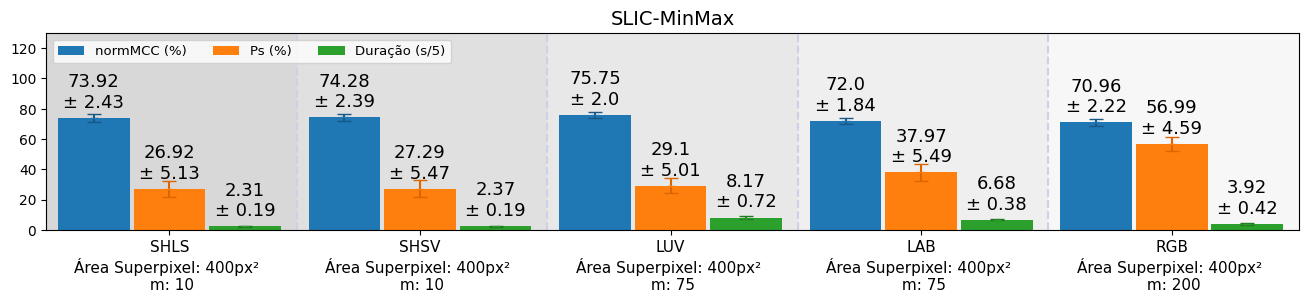

In [60]:
# Test New 3 Bars ---
plt.figure(figsize=[13.19, 2.9])
width = 9
spacing_between_bars = 0.5
spacing_between_labels = 3
overBarOffset = 17

plt_bars_with_spacing(
    {metric: to_render[metric] for metric in to_render["features_labels"]},
    
    to_render["labels"],
    
    {metric: [*map(lambda metric_val: str(metric_val).replace(" ", "\n", 1), to_render[metric])] 
    for metric in to_render["features_labels"]},
    
    width,
    spacing_between_bars,
    spacing_between_labels,
    overBarOffset,
    fontsize=13,
    labelsFontSize=11,
    barsColors=["#1f77b4", "#ff7f0e", "#2ca02c", "#F55"],
    errorMarginColors=["#175887", "#db6600", "#217821", "#C22"]
    
    # barsColors=[ "#F55", "#1f77b4", "#ff7f0e", "#2ca02c"],
    # errorMarginColors=["#C22", "#175887", "#db6600", "#217821"]
    
)

plt.ylim([0, 130])
plt.tight_layout()
plt.margins(0.0)

size_of_single_label = ((width + spacing_between_bars) * len(to_render["features_labels"])) + spacing_between_labels
for labelIdx in range(len(to_render["labels"])):
    separationPos = (size_of_single_label*labelIdx - 0.5 * (width + spacing_between_labels))
        
    nextSeparationPos = (size_of_single_label*(labelIdx+1) - 0.5 * (width + spacing_between_labels))
    plt.axvspan(separationPos, nextSeparationPos,  facecolor=f"{(1-0.15*len(to_render["labels"]))+  0.15*(labelIdx)}", alpha=0.2, zorder=-1)
        
    plt.plot([separationPos]*2,[0, 130], ls="--", color="#cfd0e6")

plt.title(technique_label, fontsize=14)
plt.legend(loc="upper left", fontsize=9.5, ncol=len(to_render["features_labels"]))
plt.savefig(f"./analysisResults/{sort_metric}/{technique_name}/{technique_name}- OOB Bars All Color Spaces Results.png", bbox_inches="tight")
plt.show()

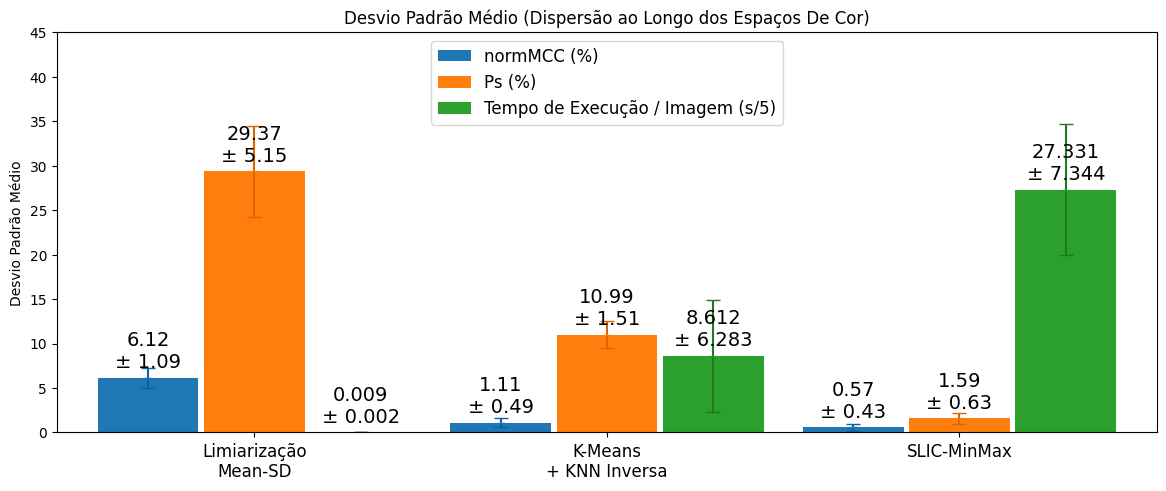

In [61]:
# Test New 3 Bars ---
width = 9
spacing_between_bars = 0.5
spacing_between_labels = 3
plt.figure(figsize=[11, 4])
overBarOffset = 3

# Mean SD Dispersion Mean along Color Spaces
# -------
# mean_MCC                  6.117 ± 1.094
# mean_balancedAccuracy     8.875 ± 1.076
# mean_normPs              29.371 ± 5.152
# mean_time_to_analyze      0.046 ± 0.01
# mean_Ps                 29.371 ± 5.152


# Mean Kmeans+KNN Dispersion Mean along Color Spaces
# -------
# mean_MCC                    1.11 ± 0.487
# mean_balancedAccuracy      0.705 ± 0.252
# mean_normPs               10.993 ± 1.513
# mean_time_to_analyze    43.059 ± 31.415
# mean_Ps                  10.993 ± 1.513

# Mean SLIC-MinMax Dispersion Mean along Color Spaces 
# -------
# mean_balancedAccuracy         0.355 ± 0.048
# mean_accuracy                  0.457 ± 0.21
# mean_F1Score                  0.915 ± 0.718
# mean_MCC                      0.566 ± 0.428
# mean_time_to_analyze          136.655 ± 36.718
# mean_overselectionIndex       3.274 ± 1.238
# mean_recall                   0.796 ± 0.112
# mean_precision                 1.862 ± 1.65
# mean_normPs                   1.587 ± 0.627
# mean_Ps                    1.587 ± 0.627



# Mean-SD; KNN; SLIC
dataToPlotNow =     {
        "normMCC (%)": [
            numberWithUncertainty.from_str("6.12 ± 1.09"),
            numberWithUncertainty.from_str("1.11 ± 0.49"),
            numberWithUncertainty.from_str("0.57 ± 0.43")
        ],
        "Ps (%)": [
            numberWithUncertainty.from_str("29.37 ± 5.15"),
            numberWithUncertainty.from_str("10.99 ± 1.51"),
            numberWithUncertainty.from_str("1.59 ± 0.63")
        ],
        "Tempo de Execução / Imagem (s/5)": [
            numberWithUncertainty.from_str("0.046 ± 0.01")/5,
            numberWithUncertainty.from_str("43.059 ± 31.415")/5,
            numberWithUncertainty.from_str("136.655 ± 36.718")/5,
        ]
    }

plt_bars_with_spacing(
    dataToPlotNow,
    
    ["Limiarização\nMean-SD", "K-Means\n+ KNN Inversa", "SLIC-MinMax"],
    
    {attribute: [str(val).replace(" ±", "\n±") for val in dataToPlotNow[attribute]] for attribute in dataToPlotNow.keys()},
    
    width,
    spacing_between_bars,
    spacing_between_labels,
    overBarOffset,
    fontsize=14,
    labelsFontSize=12,
    barsColors=["#1f77b4", "#ff7f0e", "#2ca02c", "#F55"],
    # barsColors=["#F55"],
    
    errorMarginColors=["#0a63a3", "#db6600", "#217821", "#C22"]
    # errorMarginColors=["#C22"]
    # None
)

plt.title("Desvio Padrão Médio (Dispersão ao Longo dos Espaços De Cor)")
plt.ylabel("Desvio Padrão Médio")
plt.margins(.04)

plt.ylim([0, 45])
plt.legend(loc="upper left")

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.legend(loc="upper center", fontsize=12)
plt.savefig(f"./analysisResults/{technique_name} - Mean - Mean SD Along All HPs - Along All Color Spaces .png", bbox_inches="tight")
plt.show(block=True)

### Top-1 Method From Each Color Space (normMCC Summary)

In [62]:
mean_sd = [
    numberWithUncertainty.from_str("76.81 ± 1.57"),
    numberWithUncertainty.from_str("76.53 ± 1.66"),
    numberWithUncertainty.from_str("75.05 ± 1.42"),
    numberWithUncertainty.from_str("75.99 ± 1.63"),
    numberWithUncertainty.from_str("70.18 ± 2.42"), 
]

kmeans_knn = [
    numberWithUncertainty.from_str("75.35 ± 2.37"),
    numberWithUncertainty.from_str("74.69 ± 2.19"),
    numberWithUncertainty.from_str("76.01 ± 1.94"),
    numberWithUncertainty.from_str("75.07 ± 1.85"),
    numberWithUncertainty.from_str("74.93 ± 2.02"),
]

slic_min_max = [
    numberWithUncertainty.from_str("78.28 ± 2.03"),
    numberWithUncertainty.from_str("78.21 ± 2.03"),
    numberWithUncertainty.from_str("72.0 ± 1.84"),
    numberWithUncertainty.from_str("75.75 ± 2.0"),
    numberWithUncertainty.from_str("70.96 ± 2.22"),
]

min_max = [
    76.25,
    76.91,
    80.22,
    81.66,
    81.67  
]

crr_method_data = slic_min_max
crr_method_data = np.array( [*map(lambda val: val.value, crr_method_data)] )

print(f"Mean ± SD: {mean_w_precision(crr_method_data)}")
print(f"Amplitude: {crr_method_data.max() - crr_method_data.min()}")
print(f"MIN: {crr_method_data.min()}; MAX: {crr_method_data.max()}")

Mean ± SD: 75.04 ± 3.064
Amplitude: 7.320000000000007
MIN: 70.96; MAX: 78.28


### Afforestation Class Prevalence

In [63]:

prevalences = []
condo_ds_collection_example = color_space_oriented_df.iloc[0, 0]
for condo_ds in condo_ds_collection_example:
    confusion_matrix = condo_ds["classification_evaluation_metrics"]["typesDistribution"]
    TP, TN, FP, FN = confusion_matrix["TP"], confusion_matrix["TN"], confusion_matrix["FP"], confusion_matrix["FN"]
    P = TP + FN
    N = TN + FP 
    
    prevalence = round(100*P/(P+N), 2)
    prevalences.append(prevalence)

prevalences = np.array(prevalences)
prevalence_df = pd.DataFrame()
prevalence_df["Prevalência"] = prevalences
display(prevalence_df.T)

print(f"Mean ± SD: {mean_w_precision(prevalences)}")
print(f"Amplitude: {prevalences.max() - prevalences.min()}")
print(f"MIN: {prevalences.min()}; MAX: {prevalences.max()}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Prevalência,19.21,12.14,12.1,42.6,7.58,7.15,56.34,17.99,8.23,4.78,14.36,24.33,12.73,38.61


Mean ± SD: 19.868 ± 14.879
Amplitude: 51.56
MIN: 4.78; MAX: 56.34


### Scale Factor (Summary)

In [64]:

scale_list = [0.3076923076923077,0.2150537634408602,0.2222222222222222,0.07692307692307693,0.23255813953488372,0.25641025641025644,0.36363636363636365,0.1801801801801802,0.1801801801801802,0.25641025641025644,0.12195121951219513,0.14925373134328357,0.14492753623188406,0.10101010101010101]
scale_list = np.array(scale_list).round(3)

airbus_sources = [6,5,9,11,12,13,1,7,2,4,8,10]
other_sources = [0, 3]
scale_list = scale_list[airbus_sources]
# scale_list = scale_list[other_sources]

display(pd.DataFrame(scale_list).T)
print(f"Mean ± SD: {mean_w_precision(scale_list)}")
print(f"Amplitude: {scale_list.max() - scale_list.min()}")
print(f"MIN: {scale_list.min()}; MAX: {scale_list.max()}")

# with open("xxx.txt", "w") as f:
#     f.write(pd.DataFrame(scale_list).T.to_latex())

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.364,0.256,0.256,0.149,0.145,0.101,0.215,0.18,0.222,0.233,0.18,0.122


Mean ± SD: 0.202 ± 0.069
Amplitude: 0.263
MIN: 0.101; MAX: 0.364


### Distribution of Image Sources

In [65]:
# "5": "Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023" 
# "6": "Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023" 
# "7": "Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023"
# "9": "Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023"
# "11":"Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023"
# "12":"Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023"
# "13":"Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023"

# "1": "Imagery ©2022 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2022" 
# "2": "Imagery ©2022 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2022" 
# "4": "Imagery ©2022 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2022"

# "8": "Imagery ©2023 Airbus, Map data ©2023"
# "10":"Imagery ©2023 Airbus, Map data ©2023"

# "0": "Map data ©2022"
# "3": "Map data ©2022. Map data ©2022" 

sources = {
    "Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023": 7,
    "Imagery ©2022 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2022": 3,
    "Imagery ©2023 Airbus, Map data ©2023": 2,
    "Map data ©2022": 1,
    "Map data ©2022. Map data ©2022": 1
}

summation = np.array([*sources.values()]).sum()
table = {}
for source, freq in sources.items():
    percentual_freq = round(100*freq/summation, 2)
    print(f"{freq}/{summation}")
    print(f"{percentual_freq} | {source}")
    table[source] = {"Percentual do Dataset": percentual_freq}
    
df = pd.DataFrame(table)
with open("analysisResults/latex/latex_distribution_maps_image_providers.txt", "w") as f:
    f.write(df.T.to_latex())

7/14
50.0 | Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023
3/14
21.43 | Imagery ©2022 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2022
2/14
14.29 | Imagery ©2023 Airbus, Map data ©2023
1/14
7.14 | Map data ©2022
1/14
7.14 | Map data ©2022. Map data ©2022


### From Best Method From Each Color Space, Which One is Best?

In [66]:
best_methods_on_color_spaces = []
for color_space in oob_best_method_per_color_space.keys():
    best_method_from_crr_color_space = f"{color_space.replace("_results", "")} {oob_best_method_per_color_space[color_space][0]}"
    best_methods_on_color_spaces.append(best_method_from_crr_color_space)
    
data_best_methods_on_color_spaces = oob_eval_methods_results_unpacked.loc[best_methods_on_color_spaces]
print(f"Best Methods Compared: {data_best_methods_on_color_spaces.index}")
best_method_per_color_space_per_sample = identify_best_methods_p_sample(data_best_methods_on_color_spaces, top_n_methods_to_look=1)
best_method_per_color_space = reduce_df_dim(pd.DataFrame(best_method_per_color_space_per_sample).stack().reset_index(), 0)
best_method_per_color_space_frequency = summary_unique_b_method_from_oob(best_method_per_color_space)

best_method_per_color_space_frequency = best_method_per_color_space_frequency.rename(lambda method_name: 
        method_key_to_HPs_labels(method_name, method_key_to_HPs_labels_mapper).replace("_", ".")
)

# best_method_per_color_space_frequency = best_method_per_color_space_frequency[["Was The Best in How Many Samples", *metrics_to_track]]
best_method_per_color_space_frequency = best_method_per_color_space_frequency[["Was The Best in How Many Samples", "mean_MCC", "mean_time_to_analyze", "mean_Ps"]]
best_method_per_color_space_frequency = rename_metrics_cols_from_keys_to_labels(best_method_per_color_space_frequency)

display(best_method_per_color_space_frequency)
await dfi.export_async(
    best_method_per_color_space_frequency.apply(convert_df_cells_to_str)
    .style
        .set_caption(f"Melhor Resultado Entre os Melhores Métodos de Cada Espaço de Cor")
        .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    ,
    f"./analysisResults/{sort_metric}/{technique_name}/Best Methods Among top-1 method from each color space.png"
)

Best Methods Compared: Index(['SHLS SLIC_minmax_spxArea_400_m_10',
       'SHSV SLIC_minmax_spxArea_400_m_10', 'LAB SLIC_minmax_spxArea_400_m_75',
       'LUV SLIC_minmax_spxArea_400_m_75',
       'RGB SLIC_minmax_spxArea_400_m_200'],
      dtype='object')


,Melhor Método em Amostras (%),normMCC (%),Duração (s),Ps (%)
RGB Área Superpixel: 400px² | m: 200,74.0,70.962 ± 2.216,19.621 ± 2.104,56.993 ± 4.585
LAB Área Superpixel: 400px² | m: 75,26.0,71.995 ± 1.84,33.382 ± 1.903,37.968 ± 5.492


### K-Means Cluster Quality (Davies Bouldin index)

---

In [67]:
%%script True
methods_davie_accuracy_correlation = {}
color_spaces_davies_accuracy_correlation = {}
all_davie_accuracy_correlation = {"kmeans_c": [], "sort_metric": []}

for color_space in color_space_oriented_df:
    methods_davie_accuracy_correlation[color_space] = {}
    color_spaces_davies_accuracy_correlation[color_space] = {}
    
    methods_condos_ds_df = pd.DataFrame(color_space_oriented_df[color_space].to_dict())
    
    for crr_tecnique in methods_condos_ds_df.keys():
        # crr_method_props = pd.DataFrame(methods_condos_ds_df[method].to_dict()).T
        crr_method_props = reduce_df_dim(methods_condos_ds_df, crr_tecnique)
        # crr_method_metrics = pd.DataFrame(crr_method_props["classification_evaluation_metrics"].to_dict()).T
        crr_method_metrics = reduce_df_dim( pd.DataFrame(crr_method_props), "classification_evaluation_metrics")
        
        # ---
        all_davie_accuracy_correlation["kmeans_davies_boudin"] += crr_method_props["kmeans_davies_boudin"].to_list()
        all_davie_accuracy_correlation["sort_metric"] += crr_method_metrics[sort_metric].to_list()
        
        methods_davie_accuracy_correlation[color_space][crr_tecnique] = scipy.stats.pearsonr(
            crr_method_props["kmeans_davies_boudin"].to_list(),
            crr_method_metrics[sort_metric].to_list()
        ).statistic
        
    color_spaces_davies_accuracy_correlation[color_space][f"mean_{sort_metric}"] = np.array([*methods_davie_accuracy_correlation[color_space].values()]).mean()
    color_spaces_davies_accuracy_correlation[color_space]["std"] = np.array([*methods_davie_accuracy_correlation[color_space].values()]).mean()

Couldn't find program: 'True'


In [68]:
%%script True
scipy.stats.pearsonr(all_davie_accuracy_correlation["kmeans_davies_boudin"], all_davie_accuracy_correlation["sort_metric"]).statistic

Couldn't find program: 'True'


In [69]:
%%script True
color_spaces_davies_accuracy_correlation

Couldn't find program: 'True'
